# Hyper-parameters

In [ ]:
dir_name = "Model7" #location to save the model in Google Drive

In [ ]:
n_Gen = 4 #number of generators
h_Dim = 128 #dimention of hidden layers
latent_dim =  64 # dimention of input noise
size_dataset =  200000 #size of dataset
batch_size = 128 #number of batches

steps_per_epoch = (size_dataset//batch_size)//n_Gen

# Adding Libraries

In [ ]:
import matplotlib.pyplot as plt
from sklearn import mixture

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model
from google.colab import output

import os

In [ ]:
# for saving GIF
!pip install pygifsicle
!sudo apt-get install gifsicle
import imageio
import glob
from pygifsicle import optimize
output.clear()
print("Done")

Done


# To see if we have a GPU

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.gpu_device_name())

Num GPUs Available:  1
/device:GPU:0


# Mount Google drive to save model and data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

if os.path.exists(f'/content/drive/MyDrive/{dir_name}') == False:
    os.mkdir(f'/content/drive/MyDrive/{dir_name}')
    os.mkdir(f'/content/drive/MyDrive/{dir_name}/Charts')

Mounted at /content/drive


# Producing Dataset
#### A Gaussian Mixture Model with 5 Peaks at 10, 20, 60, 80 and 110 and variance of 3, 3, 2, 2 and 1 respectively

In [ ]:
def dataset1_func(size_dataset, random_state = None):
    #comment the random_state below for final execution
    gmm = mixture.GaussianMixture(5, random_state = random_state)
    gmm.means_ = tf.constant([[10], [20], [60], [80], [110]])
    gmm.covariances_ = tf.constant([[[3]], [[3]], [[2]], [[2]], [[1]]]) ** 2
    gmm.weights_ = tf.constant([0.2, 0.2, 0.2, 0.2, 0.2])
    gmm.get_params()
    X = gmm.sample(size_dataset)
    # plt.hist(X[0], size_dataset, histtype='stepfilled', alpha=1)
    return X[0]

# Some Functions

##### A function that produces uniform random noise in the range of [-1,1] of size [n_gen, batch_size, latent_dim] as the generators' input

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, batch_size, n_Gen):
    # generate points in the latent space
    x_input = tf.random.uniform(minval = -1, maxval = 1, dtype=tf.float64, shape = [n_Gen, batch_size, latent_dim])
    # reshape into a batch of inputs for the network
    noise = []
    for i in range(n_Gen):
        noise.append(x_input[i])
    return noise

##### A callback which runs at end of each epoch to save and plot the results

In [ ]:
class GANMonitor1(tf.keras.callbacks.Callback):
    def __init__(self, dataset, plot_freq = 1, num_samples = 20000, latent_dim = 64, n_Gen = 4, dir_name = 'Model'):
        self.dataset = dataset
        self.num_samples = num_samples
        self.latent_dim = latent_dim
        self.n_Gen = n_Gen
        self.dir_name = dir_name
        self.plot_freq = plot_freq

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.plot_freq == 0:
            random_latent_vectors = generate_latent_points(self.latent_dim, self.num_samples, self.n_Gen)
            plt.hist(self.dataset, 1200, histtype='bar', density=True, alpha=0.5)
            plt.xlim(0,120)
            plt.ylim(0,0.2)
            for g in range(self.n_Gen):
                generated_samples = self.model.generators[g](random_latent_vectors[g])
                plt.hist(generated_samples.numpy(), 1200, histtype='bar', density=True, alpha=0.5)
            plt.savefig(f'/content/drive/MyDrive/{self.dir_name}/Charts/chart_{(epoch + 1):04}.png', dpi=200, format="png")
            
            # To show the plots in colab comment line below and uncomment the next line
            # plt.close()
            plt.show()

##### same as `GANMonitor1` but with different shape of plotting

In [ ]:
class GANMonitor2(tf.keras.callbacks.Callback):
    def __init__(self, dataset, plot_freq = 1, num_samples = 20000, latent_dim = 64, n_Gen = 4, dir_name = 'Model'):
        self.dataset = dataset
        self.num_samples = num_samples
        self.latent_dim = latent_dim
        self.n_Gen = n_Gen
        self.dir_name = dir_name
        self.plot_freq = plot_freq

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.plot_freq == 0:
            random_latent_vectors = generate_latent_points(self.latent_dim, self.num_samples, self.n_Gen)

            generated_samples = []
            for g in range(self.n_Gen):
                generated_samples.append(self.model.generators[g](random_latent_vectors[g]))

            combined_generated_samples = tf.concat([generated_samples[g] for g in range(self.n_Gen)], axis=0)

            ax1 = plt.subplot(313)
            ax1.hist(self.dataset, 1200, histtype='bar', density=True, alpha=0.5)
            ax1.hist(combined_generated_samples.numpy(), 1200, histtype='bar', density=True, alpha=0.5)
            ax1.set_title('All Generators together')
            ax1.set_xlim([0,120])
            ax1.set_ylim([0,0.2])

            ax2 = plt.subplot(321)
            ax2.hist(self.dataset, 1200, histtype='bar', density=True, alpha=0.5)
            ax2.hist(generated_samples[0].numpy(), 1200, histtype='bar', density=True, alpha=0.5)
            ax2.set_title('First Generator')
            ax2.set_xlim([0,120])
            ax2.set_ylim([0,0.2])

            ax3 = plt.subplot(322)
            ax3.hist(self.dataset, 1200, histtype='bar', density=True, alpha=0.5)
            ax3.hist(generated_samples[1].numpy(), 1200, histtype='bar', density=True, alpha=0.5)
            ax3.set_title('Second Generator')
            ax3.set_xlim([0,120])
            ax3.set_ylim([0,0.2])

            ax4 = plt.subplot(323)
            ax4.hist(self.dataset, 1200, histtype='bar', density=True, alpha=0.5)
            ax4.hist(generated_samples[2].numpy(), 1200, histtype='bar', density=True, alpha=0.5)
            ax4.set_title('Third Generator')
            ax4.set_xlim([0,120])
            ax4.set_ylim([0,0.2])

            ax5 = plt.subplot(324)
            ax5.hist(self.dataset, 1200, histtype='bar', density=True, alpha=0.5)
            ax5.hist(generated_samples[3].numpy(), 1200, histtype='bar', density=True, alpha=0.5)
            ax5.set_title('Forth Generator')
            ax5.set_xlim([0,120])
            ax5.set_ylim([0,0.2])

            plt.tight_layout()            
            plt.savefig(f'/content/drive/MyDrive/{self.dir_name}/Charts/chart_{(epoch + 1):04}.png', dpi=200, format="png")

            # To show the plots in colab comment line below and uncomment the next line
            # plt.close()
            plt.show()

##### Loss function for the generators based on the MAD_GAN paper

In [ ]:
@tf.function
def Generators_loss_function(y_true, y_pred):
    logarithm = -tf.math.log(y_pred[:,-1] + 1e-15)
    return tf.reduce_mean(logarithm, axis=-1)

# Defining Discriminator Model

In [ ]:
# define the standalone discriminator model
def define_discriminator(n_Gen, h_Dim):
    inp = Input(shape=(1,))
    x = Dense(h_Dim,input_shape=(1,))(inp)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(h_Dim)(x)
    x = LeakyReLU(alpha=0.2)(x)
    out = Dense(n_Gen+1, activation="softmax")(x)
    model = Model(inp, out, name="discriminator")
    return model

# Defining Generators Model

In [ ]:
def define_generators(n_Gen, latent_dim, h_Dim):
    mid_layer1 = Dense(h_Dim, name = "hidden_1", activation = 'elu', input_shape=(latent_dim,))
    mid_layer2 = Dense(h_Dim, name = "hidden_2", activation = 'elu')

    models = []
    for g in range(n_Gen):
        input = Input(shape=(latent_dim,), dtype = tf.float64, name=f"input_{g}")
        x = mid_layer1(input)
        x = mid_layer2(x)
        x = Dense(1, dtype = tf.float64, name=f"generator_output_{g}")(x)
        models.append(Model(input, x, name = f"generator{g}"))
    return models

# Defining MADGAN Class for training via keras

In [ ]:
class MADGAN(tf.keras.Model):
    def __init__(self, discriminator, generators, latent_dim, n_Gen):
        super(MADGAN, self).__init__()
        self.discriminator = discriminator
        self.generators = generators
        self.latent_dim = latent_dim
        self.n_Gen = n_Gen

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(MADGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def train_step(self, data):
        # Unpack the data
        if isinstance(data, tuple):
            X = data[0]
        else:
            X = data
        
        # Get the batch size
        batch_size = tf.shape(X)[0]
        # Sample random points in the latent space
        random_latent_vectors = generate_latent_points(self.latent_dim, batch_size//self.n_Gen, self.n_Gen)
        # Decode them to fake generator output
        x_generator = []
        for g in range(self.n_Gen):
            x_generator.append(self.generators[g](random_latent_vectors[g]))

        # Combine them with real samples
        combined_samples = tf.concat([x_generator[g] for g in range(self.n_Gen)] + 
                                     [X], 
                                     axis=0
                                     )

        # Assemble labels discriminating real from fake samples
        labels = tf.concat([tf.one_hot(g * tf.ones(batch_size//self.n_Gen, dtype=tf.int32), self.n_Gen + 1) for g in range(self.n_Gen)] + 
                    [tf.one_hot(self.n_Gen * tf.ones(batch_size, dtype=tf.int32), self.n_Gen + 1)], 
                    axis=0
                    )

        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(shape = tf.shape(labels), minval = -1, maxval = 1)

        #######################
        # Train Discriminator #
        #######################
        
        # make weights in the discriminator trainable
        with tf.GradientTape() as tape:
            # Discriminator forward pass
            predictions = self.discriminator(combined_samples)

            # Compute the loss value
            # (the loss function is configured in `compile()`)
            d_loss = self.d_loss_fn(labels, predictions)

        # Compute gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)


        # Update weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        #######################
        #   Train Generator   #
        #######################

        # Assemble labels that say "all real samples"
        misleading_labels =  tf.one_hot(self.n_Gen * tf.ones(batch_size//self.n_Gen, dtype=tf.int32), self.n_Gen + 1)

        # (note that we should *not* update the weights of the discriminator)!
        g_loss_list = []
        for g in range(self.n_Gen):
            with tf.GradientTape() as tape:
                # Generator[g] and discriminator forward pass
                predictions = self.discriminator(self.generators[g](random_latent_vectors[g]))

                # Compute the loss value
                # (the loss function is configured in `compile()`)
                g_loss = self.g_loss_fn(misleading_labels, predictions)

            # Compute gradients
            grads = tape.gradient(g_loss, self.generators[g].trainable_weights)
            # Update weights
            self.g_optimizer[g].apply_gradients(zip(grads, self.generators[g].trainable_weights))
            g_loss_list.append(g_loss)

        mydict = {f"g_loss{g}": g_loss_list[g] for g in range(self.n_Gen)}
        mydict.update({"d_loss": d_loss})
        return mydict

# Creating Model and training it

Epoch 1/200
390/390 [==============================] - 11s 17ms/step - g_loss0: 1.1650 - g_loss1: 1.1169 - g_loss2: 1.1327 - g_loss3: 1.2254 - d_loss: 1.1532
Epoch 2/200
390/390 [==============================] - 7s 19ms/step - g_loss0: 0.8615 - g_loss1: 0.8288 - g_loss2: 0.8428 - g_loss3: 0.9725 - d_loss: 1.4152
Epoch 3/200
390/390 [==============================] - 7s 19ms/step - g_loss0: 0.9979 - g_loss1: 0.9998 - g_loss2: 0.9995 - g_loss3: 0.9916 - d_loss: 1.4129
Epoch 4/200
390/390 [==============================] - 7s 18ms/step - g_loss0: 0.7229 - g_loss1: 0.7305 - g_loss2: 0.7278 - g_loss3: 0.6973 - d_loss: 1.3690
Epoch 5/200
390/390 [==============================] - 7s 18ms/step - g_loss0: 0.6656 - g_loss1: 0.6643 - g_loss2: 0.6650 - g_loss3: 0.6681 - d_loss: 1.3639


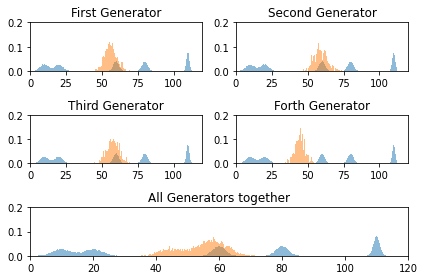

Epoch 6/200
390/390 [==============================] - 7s 18ms/step - g_loss0: 0.6986 - g_loss1: 0.6978 - g_loss2: 0.6983 - g_loss3: 0.6971 - d_loss: 1.3369
Epoch 7/200
390/390 [==============================] - 7s 18ms/step - g_loss0: 0.7027 - g_loss1: 0.7011 - g_loss2: 0.7015 - g_loss3: 0.6992 - d_loss: 1.3254
Epoch 8/200
390/390 [==============================] - 7s 19ms/step - g_loss0: 0.7000 - g_loss1: 0.6992 - g_loss2: 0.6958 - g_loss3: 0.6928 - d_loss: 1.3160
Epoch 9/200
390/390 [==============================] - 8s 21ms/step - g_loss0: 0.6827 - g_loss1: 0.6826 - g_loss2: 0.6819 - g_loss3: 0.7083 - d_loss: 1.2429
Epoch 10/200
390/390 [==============================] - 8s 19ms/step - g_loss0: 0.6873 - g_loss1: 0.6869 - g_loss2: 0.6868 - g_loss3: 0.6668 - d_loss: 1.1726


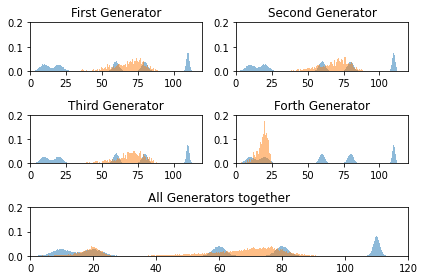

Epoch 11/200
390/390 [==============================] - 7s 18ms/step - g_loss0: 0.7173 - g_loss1: 0.7173 - g_loss2: 0.7173 - g_loss3: 0.6272 - d_loss: 1.1668
Epoch 12/200
390/390 [==============================] - 8s 19ms/step - g_loss0: 0.7222 - g_loss1: 0.7226 - g_loss2: 0.7217 - g_loss3: 0.6444 - d_loss: 1.2527
Epoch 13/200
390/390 [==============================] - 7s 19ms/step - g_loss0: 0.7063 - g_loss1: 0.7067 - g_loss2: 0.7065 - g_loss3: 0.6962 - d_loss: 1.2660
Epoch 14/200
390/390 [==============================] - 8s 22ms/step - g_loss0: 0.6905 - g_loss1: 0.6894 - g_loss2: 0.6896 - g_loss3: 0.7303 - d_loss: 1.2427
Epoch 15/200
390/390 [==============================] - 7s 19ms/step - g_loss0: 0.6944 - g_loss1: 0.6942 - g_loss2: 0.6937 - g_loss3: 0.6921 - d_loss: 1.2117


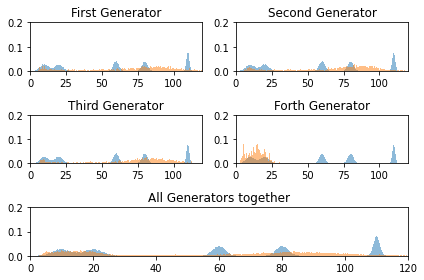

Epoch 16/200
390/390 [==============================] - 7s 19ms/step - g_loss0: 0.7059 - g_loss1: 0.7061 - g_loss2: 0.7051 - g_loss3: 0.6761 - d_loss: 1.2301
Epoch 17/200
390/390 [==============================] - 8s 19ms/step - g_loss0: 0.6979 - g_loss1: 0.6977 - g_loss2: 0.6971 - g_loss3: 0.6971 - d_loss: 1.2372
Epoch 18/200
390/390 [==============================] - 8s 20ms/step - g_loss0: 0.6958 - g_loss1: 0.6958 - g_loss2: 0.6954 - g_loss3: 0.7012 - d_loss: 1.2321
Epoch 19/200
390/390 [==============================] - 9s 22ms/step - g_loss0: 0.6954 - g_loss1: 0.6956 - g_loss2: 0.6950 - g_loss3: 0.7011 - d_loss: 1.2292
Epoch 20/200
390/390 [==============================] - 8s 20ms/step - g_loss0: 0.6963 - g_loss1: 0.6964 - g_loss2: 0.6960 - g_loss3: 0.7018 - d_loss: 1.2245


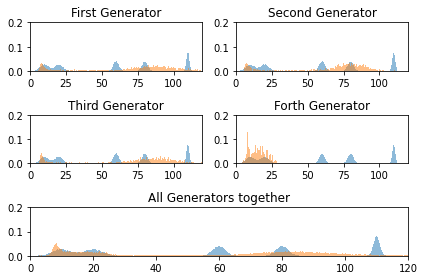

Epoch 21/200
390/390 [==============================] - 7s 19ms/step - g_loss0: 0.6979 - g_loss1: 0.6979 - g_loss2: 0.6973 - g_loss3: 0.6996 - d_loss: 1.2237
Epoch 22/200
390/390 [==============================] - 8s 20ms/step - g_loss0: 0.6979 - g_loss1: 0.6978 - g_loss2: 0.6973 - g_loss3: 0.6972 - d_loss: 1.2213
Epoch 23/200
390/390 [==============================] - 8s 20ms/step - g_loss0: 0.6973 - g_loss1: 0.6970 - g_loss2: 0.6966 - g_loss3: 0.7019 - d_loss: 1.2223
Epoch 24/200
390/390 [==============================] - 9s 23ms/step - g_loss0: 0.6992 - g_loss1: 0.6993 - g_loss2: 0.6989 - g_loss3: 0.6960 - d_loss: 1.2188
Epoch 25/200
390/390 [==============================] - 8s 20ms/step - g_loss0: 0.7023 - g_loss1: 0.7029 - g_loss2: 0.7024 - g_loss3: 0.6930 - d_loss: 1.2154


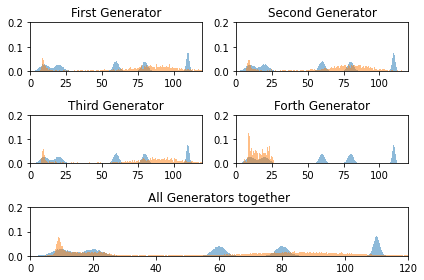

Epoch 26/200
390/390 [==============================] - 8s 20ms/step - g_loss0: 0.6987 - g_loss1: 0.6984 - g_loss2: 0.6984 - g_loss3: 0.6960 - d_loss: 1.2131
Epoch 27/200
390/390 [==============================] - 8s 21ms/step - g_loss0: 0.7019 - g_loss1: 0.7025 - g_loss2: 0.7017 - g_loss3: 0.6950 - d_loss: 1.2118
Epoch 28/200
390/390 [==============================] - 8s 21ms/step - g_loss0: 0.7013 - g_loss1: 0.7013 - g_loss2: 0.7006 - g_loss3: 0.6951 - d_loss: 1.2101
Epoch 29/200
390/390 [==============================] - 9s 23ms/step - g_loss0: 0.7020 - g_loss1: 0.7019 - g_loss2: 0.7016 - g_loss3: 0.6950 - d_loss: 1.2063
Epoch 30/200
390/390 [==============================] - 8s 21ms/step - g_loss0: 0.7007 - g_loss1: 0.7014 - g_loss2: 0.7003 - g_loss3: 0.6971 - d_loss: 1.2048


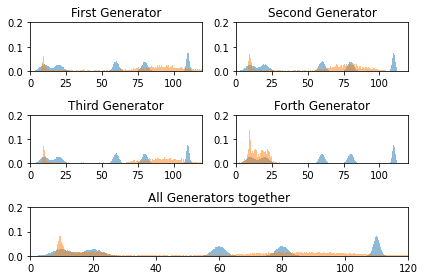

Epoch 31/200
390/390 [==============================] - 8s 20ms/step - g_loss0: 0.7020 - g_loss1: 0.7033 - g_loss2: 0.7022 - g_loss3: 0.6942 - d_loss: 1.2015
Epoch 32/200
390/390 [==============================] - 8s 21ms/step - g_loss0: 0.7046 - g_loss1: 0.7099 - g_loss2: 0.7035 - g_loss3: 0.6833 - d_loss: 1.1946
Epoch 33/200
390/390 [==============================] - 8s 20ms/step - g_loss0: 0.7037 - g_loss1: 0.7102 - g_loss2: 0.7042 - g_loss3: 0.6753 - d_loss: 1.1823
Epoch 34/200
390/390 [==============================] - 9s 23ms/step - g_loss0: 0.7058 - g_loss1: 0.7116 - g_loss2: 0.7071 - g_loss3: 0.6727 - d_loss: 1.1782
Epoch 35/200
390/390 [==============================] - 8s 20ms/step - g_loss0: 0.7061 - g_loss1: 0.7100 - g_loss2: 0.7072 - g_loss3: 0.6758 - d_loss: 1.1728


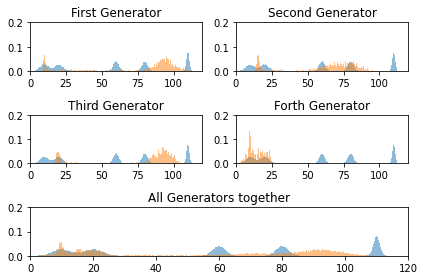

Epoch 36/200
390/390 [==============================] - 8s 21ms/step - g_loss0: 0.7072 - g_loss1: 0.7097 - g_loss2: 0.7072 - g_loss3: 0.6740 - d_loss: 1.1627
Epoch 37/200
390/390 [==============================] - 8s 20ms/step - g_loss0: 0.7050 - g_loss1: 0.7081 - g_loss2: 0.7063 - g_loss3: 0.6801 - d_loss: 1.1536
Epoch 38/200
390/390 [==============================] - 8s 21ms/step - g_loss0: 0.7050 - g_loss1: 0.7077 - g_loss2: 0.7058 - g_loss3: 0.6839 - d_loss: 1.1405
Epoch 39/200
390/390 [==============================] - 9s 23ms/step - g_loss0: 0.7087 - g_loss1: 0.7087 - g_loss2: 0.7069 - g_loss3: 0.6800 - d_loss: 1.1299
Epoch 40/200
390/390 [==============================] - 8s 21ms/step - g_loss0: 0.7088 - g_loss1: 0.7108 - g_loss2: 0.7077 - g_loss3: 0.6777 - d_loss: 1.1174


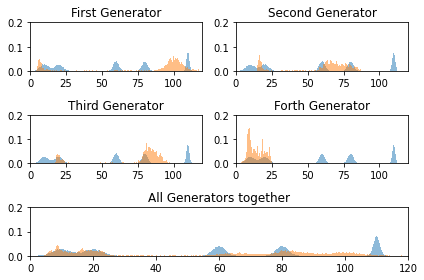

Epoch 41/200
390/390 [==============================] - 8s 20ms/step - g_loss0: 0.7062 - g_loss1: 0.7131 - g_loss2: 0.7094 - g_loss3: 0.6791 - d_loss: 1.1094
Epoch 42/200
390/390 [==============================] - 8s 22ms/step - g_loss0: 0.7050 - g_loss1: 0.7159 - g_loss2: 0.7106 - g_loss3: 0.6773 - d_loss: 1.0964
Epoch 43/200
390/390 [==============================] - 8s 21ms/step - g_loss0: 0.7041 - g_loss1: 0.7132 - g_loss2: 0.7116 - g_loss3: 0.6788 - d_loss: 1.0830
Epoch 44/200
390/390 [==============================] - 10s 24ms/step - g_loss0: 0.7047 - g_loss1: 0.7159 - g_loss2: 0.7139 - g_loss3: 0.6753 - d_loss: 1.0716
Epoch 45/200
390/390 [==============================] - 8s 21ms/step - g_loss0: 0.7043 - g_loss1: 0.7181 - g_loss2: 0.7185 - g_loss3: 0.6746 - d_loss: 1.0569


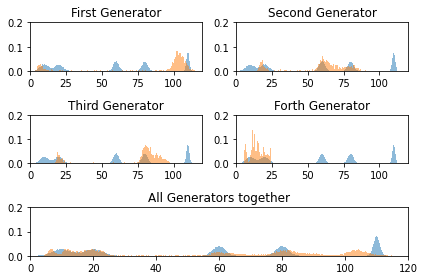

Epoch 46/200
390/390 [==============================] - 8s 21ms/step - g_loss0: 0.7060 - g_loss1: 0.7175 - g_loss2: 0.7181 - g_loss3: 0.6736 - d_loss: 1.0477
Epoch 47/200
390/390 [==============================] - 8s 22ms/step - g_loss0: 0.7055 - g_loss1: 0.7200 - g_loss2: 0.7235 - g_loss3: 0.6684 - d_loss: 1.0330
Epoch 48/200
390/390 [==============================] - 9s 22ms/step - g_loss0: 0.7119 - g_loss1: 0.7149 - g_loss2: 0.7301 - g_loss3: 0.6678 - d_loss: 1.0263
Epoch 49/200
390/390 [==============================] - 9s 24ms/step - g_loss0: 0.7092 - g_loss1: 0.7161 - g_loss2: 0.7301 - g_loss3: 0.6691 - d_loss: 1.0195
Epoch 50/200
390/390 [==============================] - 9s 22ms/step - g_loss0: 0.7033 - g_loss1: 0.7185 - g_loss2: 0.7340 - g_loss3: 0.6705 - d_loss: 1.0166


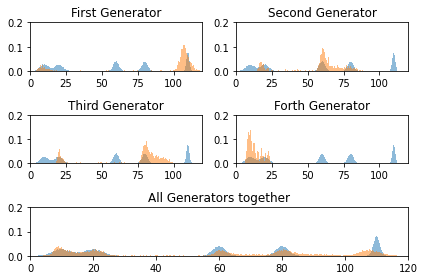

Epoch 51/200
390/390 [==============================] - 8s 21ms/step - g_loss0: 0.7039 - g_loss1: 0.7189 - g_loss2: 0.7374 - g_loss3: 0.6720 - d_loss: 1.0032
Epoch 52/200
390/390 [==============================] - 9s 22ms/step - g_loss0: 0.7014 - g_loss1: 0.7162 - g_loss2: 0.7415 - g_loss3: 0.6771 - d_loss: 1.0025
Epoch 53/200
390/390 [==============================] - 8s 22ms/step - g_loss0: 0.6976 - g_loss1: 0.7161 - g_loss2: 0.7395 - g_loss3: 0.6789 - d_loss: 0.9945
Epoch 54/200
390/390 [==============================] - 10s 25ms/step - g_loss0: 0.6991 - g_loss1: 0.7161 - g_loss2: 0.7447 - g_loss3: 0.6768 - d_loss: 0.9909
Epoch 55/200
390/390 [==============================] - 8s 22ms/step - g_loss0: 0.6906 - g_loss1: 0.7158 - g_loss2: 0.7426 - g_loss3: 0.6859 - d_loss: 0.9924


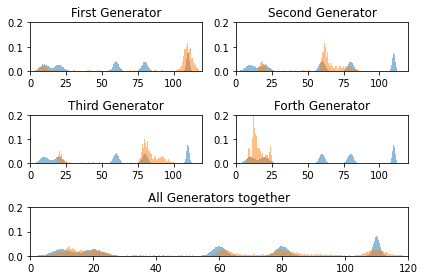

Epoch 56/200
390/390 [==============================] - 9s 22ms/step - g_loss0: 0.6864 - g_loss1: 0.7220 - g_loss2: 0.7505 - g_loss3: 0.6845 - d_loss: 0.9843
Epoch 57/200
390/390 [==============================] - 9s 22ms/step - g_loss0: 0.6838 - g_loss1: 0.7224 - g_loss2: 0.7488 - g_loss3: 0.6813 - d_loss: 0.9737
Epoch 58/200
390/390 [==============================] - 9s 22ms/step - g_loss0: 0.6713 - g_loss1: 0.7308 - g_loss2: 0.7489 - g_loss3: 0.6842 - d_loss: 0.9700
Epoch 59/200
390/390 [==============================] - 10s 25ms/step - g_loss0: 0.6670 - g_loss1: 0.7364 - g_loss2: 0.7505 - g_loss3: 0.6806 - d_loss: 0.9660
Epoch 60/200
390/390 [==============================] - 9s 22ms/step - g_loss0: 0.6617 - g_loss1: 0.7438 - g_loss2: 0.7502 - g_loss3: 0.6834 - d_loss: 0.9628


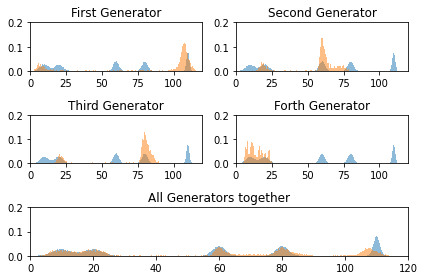

Epoch 61/200
390/390 [==============================] - 8s 22ms/step - g_loss0: 0.6642 - g_loss1: 0.7516 - g_loss2: 0.7530 - g_loss3: 0.6717 - d_loss: 0.9512
Epoch 62/200
390/390 [==============================] - 9s 23ms/step - g_loss0: 0.6671 - g_loss1: 0.7525 - g_loss2: 0.7395 - g_loss3: 0.6782 - d_loss: 0.9467
Epoch 63/200
390/390 [==============================] - 9s 22ms/step - g_loss0: 0.6666 - g_loss1: 0.7526 - g_loss2: 0.7393 - g_loss3: 0.6746 - d_loss: 0.9405
Epoch 64/200
390/390 [==============================] - 10s 26ms/step - g_loss0: 0.6721 - g_loss1: 0.7536 - g_loss2: 0.7390 - g_loss3: 0.6731 - d_loss: 0.9386
Epoch 65/200
390/390 [==============================] - 9s 23ms/step - g_loss0: 0.6676 - g_loss1: 0.7577 - g_loss2: 0.7360 - g_loss3: 0.6735 - d_loss: 0.9380


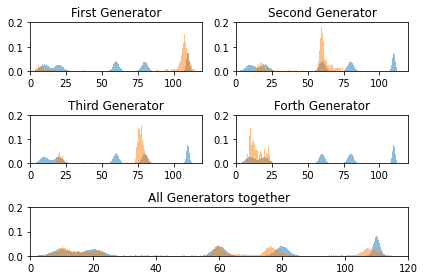

Epoch 66/200
390/390 [==============================] - 9s 22ms/step - g_loss0: 0.6689 - g_loss1: 0.7581 - g_loss2: 0.7346 - g_loss3: 0.6746 - d_loss: 0.9313
Epoch 67/200
390/390 [==============================] - 9s 23ms/step - g_loss0: 0.6690 - g_loss1: 0.7524 - g_loss2: 0.7343 - g_loss3: 0.6791 - d_loss: 0.9287
Epoch 68/200
390/390 [==============================] - 9s 23ms/step - g_loss0: 0.6688 - g_loss1: 0.7521 - g_loss2: 0.7345 - g_loss3: 0.6739 - d_loss: 0.9258
Epoch 69/200
390/390 [==============================] - 10s 26ms/step - g_loss0: 0.6697 - g_loss1: 0.7476 - g_loss2: 0.7374 - g_loss3: 0.6736 - d_loss: 0.9226
Epoch 70/200
390/390 [==============================] - 9s 23ms/step - g_loss0: 0.6699 - g_loss1: 0.7499 - g_loss2: 0.7334 - g_loss3: 0.6746 - d_loss: 0.9227


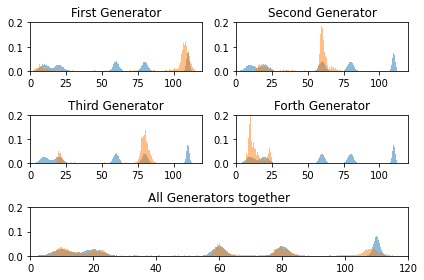

Epoch 71/200
390/390 [==============================] - 9s 22ms/step - g_loss0: 0.6715 - g_loss1: 0.7504 - g_loss2: 0.7345 - g_loss3: 0.6713 - d_loss: 0.9219
Epoch 72/200
390/390 [==============================] - 9s 24ms/step - g_loss0: 0.6694 - g_loss1: 0.7520 - g_loss2: 0.7340 - g_loss3: 0.6714 - d_loss: 0.9167
Epoch 73/200
390/390 [==============================] - 9s 23ms/step - g_loss0: 0.6676 - g_loss1: 0.7508 - g_loss2: 0.7321 - g_loss3: 0.6729 - d_loss: 0.9169
Epoch 74/200
390/390 [==============================] - 10s 26ms/step - g_loss0: 0.6721 - g_loss1: 0.7456 - g_loss2: 0.7320 - g_loss3: 0.6763 - d_loss: 0.9188
Epoch 75/200
390/390 [==============================] - 9s 23ms/step - g_loss0: 0.6719 - g_loss1: 0.7448 - g_loss2: 0.7304 - g_loss3: 0.6789 - d_loss: 0.9213


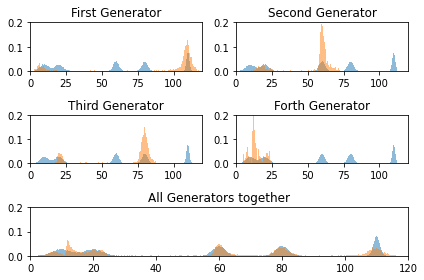

Epoch 76/200
390/390 [==============================] - 9s 23ms/step - g_loss0: 0.6724 - g_loss1: 0.7437 - g_loss2: 0.7336 - g_loss3: 0.6750 - d_loss: 0.9139
Epoch 77/200
390/390 [==============================] - 9s 23ms/step - g_loss0: 0.6758 - g_loss1: 0.7437 - g_loss2: 0.7318 - g_loss3: 0.6741 - d_loss: 0.9136
Epoch 78/200
390/390 [==============================] - 9s 24ms/step - g_loss0: 0.6748 - g_loss1: 0.7408 - g_loss2: 0.7371 - g_loss3: 0.6750 - d_loss: 0.9174
Epoch 79/200
390/390 [==============================] - 10s 26ms/step - g_loss0: 0.6737 - g_loss1: 0.7413 - g_loss2: 0.7325 - g_loss3: 0.6747 - d_loss: 0.9117
Epoch 80/200
390/390 [==============================] - 10s 24ms/step - g_loss0: 0.6770 - g_loss1: 0.7393 - g_loss2: 0.7364 - g_loss3: 0.6733 - d_loss: 0.9136


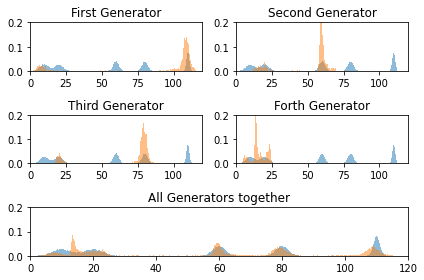

Epoch 81/200
390/390 [==============================] - 9s 22ms/step - g_loss0: 0.6773 - g_loss1: 0.7380 - g_loss2: 0.7345 - g_loss3: 0.6715 - d_loss: 0.9118
Epoch 82/200
390/390 [==============================] - 10s 25ms/step - g_loss0: 0.6745 - g_loss1: 0.7400 - g_loss2: 0.7349 - g_loss3: 0.6736 - d_loss: 0.9119
Epoch 83/200
390/390 [==============================] - 9s 24ms/step - g_loss0: 0.6737 - g_loss1: 0.7399 - g_loss2: 0.7342 - g_loss3: 0.6757 - d_loss: 0.9129
Epoch 84/200
390/390 [==============================] - 11s 27ms/step - g_loss0: 0.6766 - g_loss1: 0.7388 - g_loss2: 0.7310 - g_loss3: 0.6774 - d_loss: 0.9113
Epoch 85/200
390/390 [==============================] - 9s 24ms/step - g_loss0: 0.6749 - g_loss1: 0.7384 - g_loss2: 0.7318 - g_loss3: 0.6817 - d_loss: 0.9117


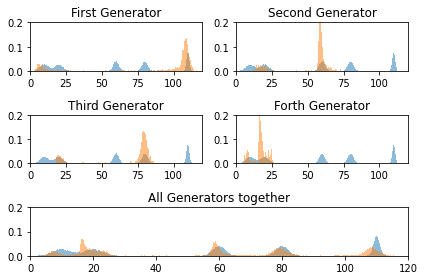

Epoch 86/200
390/390 [==============================] - 9s 24ms/step - g_loss0: 0.6751 - g_loss1: 0.7326 - g_loss2: 0.7329 - g_loss3: 0.6787 - d_loss: 0.9120
Epoch 87/200
390/390 [==============================] - 9s 24ms/step - g_loss0: 0.6751 - g_loss1: 0.7323 - g_loss2: 0.7328 - g_loss3: 0.6816 - d_loss: 0.9120
Epoch 88/200
390/390 [==============================] - 10s 25ms/step - g_loss0: 0.6761 - g_loss1: 0.7333 - g_loss2: 0.7325 - g_loss3: 0.6804 - d_loss: 0.9062
Epoch 89/200
390/390 [==============================] - 10s 27ms/step - g_loss0: 0.6734 - g_loss1: 0.7329 - g_loss2: 0.7338 - g_loss3: 0.6827 - d_loss: 0.9122
Epoch 90/200
390/390 [==============================] - 10s 25ms/step - g_loss0: 0.6809 - g_loss1: 0.7352 - g_loss2: 0.7250 - g_loss3: 0.6826 - d_loss: 0.9121


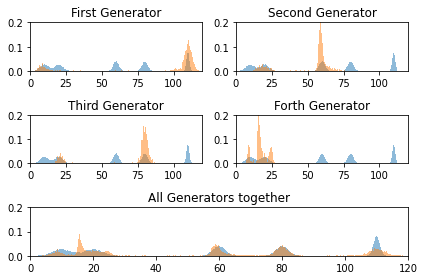

Epoch 91/200
390/390 [==============================] - 9s 23ms/step - g_loss0: 0.6735 - g_loss1: 0.7319 - g_loss2: 0.7296 - g_loss3: 0.6840 - d_loss: 0.9156
Epoch 92/200
390/390 [==============================] - 10s 25ms/step - g_loss0: 0.6743 - g_loss1: 0.7304 - g_loss2: 0.7317 - g_loss3: 0.6850 - d_loss: 0.9120
Epoch 93/200
390/390 [==============================] - 9s 24ms/step - g_loss0: 0.6759 - g_loss1: 0.7325 - g_loss2: 0.7243 - g_loss3: 0.6892 - d_loss: 0.9094
Epoch 94/200
390/390 [==============================] - 11s 29ms/step - g_loss0: 0.6761 - g_loss1: 0.7272 - g_loss2: 0.7305 - g_loss3: 0.6912 - d_loss: 0.9119
Epoch 95/200
390/390 [==============================] - 9s 24ms/step - g_loss0: 0.6744 - g_loss1: 0.7257 - g_loss2: 0.7291 - g_loss3: 0.6945 - d_loss: 0.9142


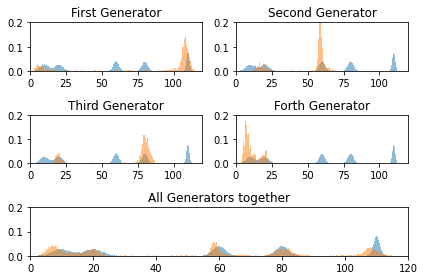

Epoch 96/200
390/390 [==============================] - 10s 25ms/step - g_loss0: 0.6743 - g_loss1: 0.7284 - g_loss2: 0.7267 - g_loss3: 0.6921 - d_loss: 0.9146
Epoch 97/200
390/390 [==============================] - 10s 25ms/step - g_loss0: 0.6749 - g_loss1: 0.7306 - g_loss2: 0.7284 - g_loss3: 0.6931 - d_loss: 0.9136
Epoch 98/200
390/390 [==============================] - 10s 25ms/step - g_loss0: 0.6602 - g_loss1: 0.7744 - g_loss2: 0.7764 - g_loss3: 0.6950 - d_loss: 0.9874
Epoch 99/200
390/390 [==============================] - 10s 27ms/step - g_loss0: 0.6693 - g_loss1: 0.6979 - g_loss2: 0.8028 - g_loss3: 0.6915 - d_loss: 0.9974
Epoch 100/200
390/390 [==============================] - 10s 25ms/step - g_loss0: 0.6558 - g_loss1: 0.7113 - g_loss2: 0.7948 - g_loss3: 0.6946 - d_loss: 1.0130


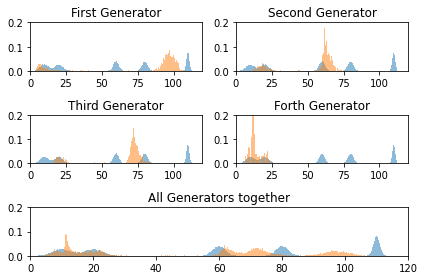

Epoch 101/200
390/390 [==============================] - 9s 24ms/step - g_loss0: 0.6660 - g_loss1: 0.7329 - g_loss2: 0.7656 - g_loss3: 0.6970 - d_loss: 1.0751
Epoch 102/200
390/390 [==============================] - 10s 26ms/step - g_loss0: 0.6789 - g_loss1: 0.7191 - g_loss2: 0.7227 - g_loss3: 0.6959 - d_loss: 1.0446
Epoch 103/200
390/390 [==============================] - 10s 25ms/step - g_loss0: 0.6763 - g_loss1: 0.7238 - g_loss2: 0.7177 - g_loss3: 0.6937 - d_loss: 1.0565
Epoch 104/200
390/390 [==============================] - 11s 28ms/step - g_loss0: 0.6795 - g_loss1: 0.7252 - g_loss2: 0.7118 - g_loss3: 0.7000 - d_loss: 1.0487
Epoch 105/200
390/390 [==============================] - 10s 25ms/step - g_loss0: 0.6988 - g_loss1: 0.7216 - g_loss2: 0.7158 - g_loss3: 0.6940 - d_loss: 1.0184


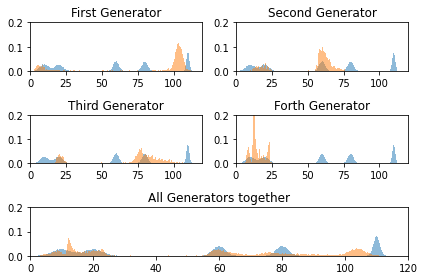

Epoch 106/200
390/390 [==============================] - 10s 25ms/step - g_loss0: 0.6979 - g_loss1: 0.7144 - g_loss2: 0.7082 - g_loss3: 0.6996 - d_loss: 1.0188
Epoch 107/200
390/390 [==============================] - 10s 26ms/step - g_loss0: 0.6998 - g_loss1: 0.7116 - g_loss2: 0.7057 - g_loss3: 0.7004 - d_loss: 1.0130
Epoch 108/200
390/390 [==============================] - 10s 26ms/step - g_loss0: 0.6978 - g_loss1: 0.7109 - g_loss2: 0.7140 - g_loss3: 0.7013 - d_loss: 1.0118
Epoch 109/200
390/390 [==============================] - 11s 28ms/step - g_loss0: 0.6962 - g_loss1: 0.7141 - g_loss2: 0.7105 - g_loss3: 0.6988 - d_loss: 1.0123
Epoch 110/200
390/390 [==============================] - 10s 26ms/step - g_loss0: 0.7023 - g_loss1: 0.7110 - g_loss2: 0.7058 - g_loss3: 0.6942 - d_loss: 1.0029


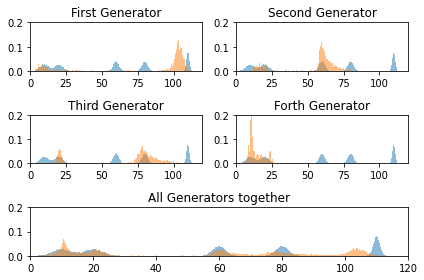

Epoch 111/200
390/390 [==============================] - 10s 25ms/step - g_loss0: 0.7038 - g_loss1: 0.7147 - g_loss2: 0.7075 - g_loss3: 0.7000 - d_loss: 1.0018
Epoch 112/200
390/390 [==============================] - 10s 26ms/step - g_loss0: 0.6958 - g_loss1: 0.7135 - g_loss2: 0.7278 - g_loss3: 0.6970 - d_loss: 1.0091
Epoch 113/200
390/390 [==============================] - 10s 26ms/step - g_loss0: 0.6958 - g_loss1: 0.7123 - g_loss2: 0.7235 - g_loss3: 0.6993 - d_loss: 1.0110
Epoch 114/200
390/390 [==============================] - 11s 29ms/step - g_loss0: 0.7018 - g_loss1: 0.7158 - g_loss2: 0.7028 - g_loss3: 0.7014 - d_loss: 0.9956
Epoch 115/200
390/390 [==============================] - 10s 25ms/step - g_loss0: 0.7075 - g_loss1: 0.7066 - g_loss2: 0.7284 - g_loss3: 0.6984 - d_loss: 0.9965


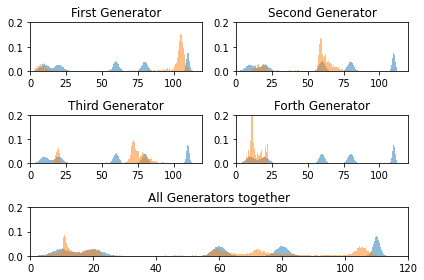

Epoch 116/200
390/390 [==============================] - 10s 26ms/step - g_loss0: 0.6950 - g_loss1: 0.7154 - g_loss2: 0.7299 - g_loss3: 0.6994 - d_loss: 1.0185
Epoch 117/200
390/390 [==============================] - 10s 26ms/step - g_loss0: 0.7065 - g_loss1: 0.7061 - g_loss2: 0.7122 - g_loss3: 0.6961 - d_loss: 1.0017
Epoch 118/200
390/390 [==============================] - 10s 27ms/step - g_loss0: 0.6987 - g_loss1: 0.7146 - g_loss2: 0.7275 - g_loss3: 0.6956 - d_loss: 1.0046
Epoch 119/200
390/390 [==============================] - 11s 29ms/step - g_loss0: 0.7094 - g_loss1: 0.7091 - g_loss2: 0.7173 - g_loss3: 0.7010 - d_loss: 1.0108
Epoch 120/200
390/390 [==============================] - 10s 26ms/step - g_loss0: 0.7012 - g_loss1: 0.7137 - g_loss2: 0.7270 - g_loss3: 0.6993 - d_loss: 1.0100


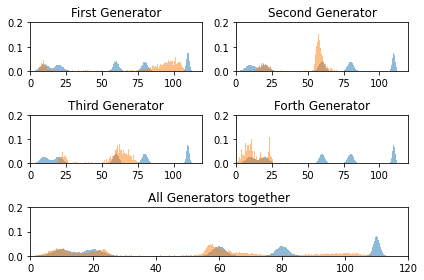

Epoch 121/200
390/390 [==============================] - 10s 25ms/step - g_loss0: 0.7107 - g_loss1: 0.6815 - g_loss2: 0.7681 - g_loss3: 0.6989 - d_loss: 1.0208
Epoch 122/200
390/390 [==============================] - 10s 27ms/step - g_loss0: 0.6870 - g_loss1: 0.7177 - g_loss2: 0.7370 - g_loss3: 0.6996 - d_loss: 1.0136
Epoch 123/200
390/390 [==============================] - 10s 26ms/step - g_loss0: 0.7064 - g_loss1: 0.7094 - g_loss2: 0.7524 - g_loss3: 0.6944 - d_loss: 1.0141
Epoch 124/200
390/390 [==============================] - 12s 30ms/step - g_loss0: 0.6901 - g_loss1: 0.7220 - g_loss2: 0.7717 - g_loss3: 0.6977 - d_loss: 1.0486
Epoch 125/200
390/390 [==============================] - 10s 26ms/step - g_loss0: 0.7071 - g_loss1: 0.6668 - g_loss2: 0.7518 - g_loss3: 0.7081 - d_loss: 1.0365


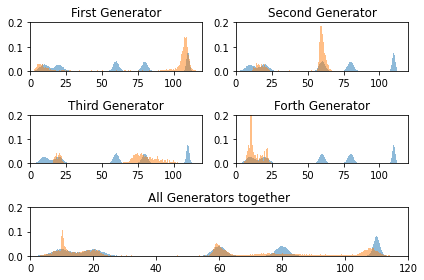

Epoch 126/200
390/390 [==============================] - 10s 26ms/step - g_loss0: 0.7190 - g_loss1: 0.6367 - g_loss2: 0.7452 - g_loss3: 0.7058 - d_loss: 1.0004
Epoch 127/200
390/390 [==============================] - 10s 27ms/step - g_loss0: 0.7188 - g_loss1: 0.6517 - g_loss2: 0.7442 - g_loss3: 0.6977 - d_loss: 0.9911
Epoch 128/200
390/390 [==============================] - 10s 27ms/step - g_loss0: 0.7024 - g_loss1: 0.7004 - g_loss2: 0.7324 - g_loss3: 0.6911 - d_loss: 1.0240
Epoch 129/200
390/390 [==============================] - 11s 29ms/step - g_loss0: 0.6999 - g_loss1: 0.7292 - g_loss2: 0.7222 - g_loss3: 0.6967 - d_loss: 1.0434
Epoch 130/200
390/390 [==============================] - 10s 27ms/step - g_loss0: 0.7054 - g_loss1: 0.6619 - g_loss2: 0.7477 - g_loss3: 0.7077 - d_loss: 1.0273


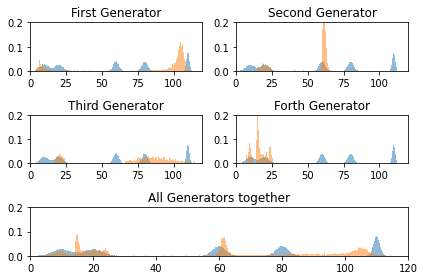

Epoch 131/200
390/390 [==============================] - 10s 25ms/step - g_loss0: 0.7066 - g_loss1: 0.6650 - g_loss2: 0.7356 - g_loss3: 0.6955 - d_loss: 1.0161
Epoch 132/200
390/390 [==============================] - 11s 28ms/step - g_loss0: 0.7139 - g_loss1: 0.6602 - g_loss2: 0.7316 - g_loss3: 0.6963 - d_loss: 1.0181
Epoch 133/200
390/390 [==============================] - 10s 26ms/step - g_loss0: 0.7162 - g_loss1: 0.6581 - g_loss2: 0.7292 - g_loss3: 0.6911 - d_loss: 1.0123
Epoch 134/200
390/390 [==============================] - 12s 30ms/step - g_loss0: 0.7235 - g_loss1: 0.6528 - g_loss2: 0.7310 - g_loss3: 0.6996 - d_loss: 1.0115
Epoch 135/200
390/390 [==============================] - 10s 27ms/step - g_loss0: 0.7202 - g_loss1: 0.6580 - g_loss2: 0.7277 - g_loss3: 0.7004 - d_loss: 1.0024


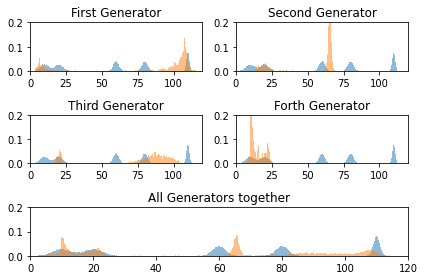

Epoch 136/200
390/390 [==============================] - 10s 26ms/step - g_loss0: 0.7254 - g_loss1: 0.6596 - g_loss2: 0.7327 - g_loss3: 0.6947 - d_loss: 0.9920
Epoch 137/200
390/390 [==============================] - 11s 27ms/step - g_loss0: 0.7250 - g_loss1: 0.6616 - g_loss2: 0.7334 - g_loss3: 0.6878 - d_loss: 0.9880
Epoch 138/200
390/390 [==============================] - 11s 28ms/step - g_loss0: 0.7225 - g_loss1: 0.6653 - g_loss2: 0.7305 - g_loss3: 0.6914 - d_loss: 0.9764
Epoch 139/200
390/390 [==============================] - 11s 29ms/step - g_loss0: 0.7293 - g_loss1: 0.6598 - g_loss2: 0.7316 - g_loss3: 0.6956 - d_loss: 0.9749
Epoch 140/200
390/390 [==============================] - 11s 28ms/step - g_loss0: 0.7246 - g_loss1: 0.6647 - g_loss2: 0.7356 - g_loss3: 0.6943 - d_loss: 0.9683


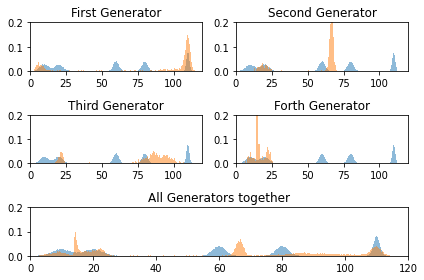

Epoch 141/200
390/390 [==============================] - 10s 26ms/step - g_loss0: 0.7209 - g_loss1: 0.6646 - g_loss2: 0.7377 - g_loss3: 0.6965 - d_loss: 0.9620
Epoch 142/200
390/390 [==============================] - 11s 29ms/step - g_loss0: 0.7246 - g_loss1: 0.6605 - g_loss2: 0.7335 - g_loss3: 0.7019 - d_loss: 0.9650
Epoch 143/200
390/390 [==============================] - 11s 27ms/step - g_loss0: 0.7172 - g_loss1: 0.6639 - g_loss2: 0.7352 - g_loss3: 0.7008 - d_loss: 0.9588
Epoch 144/200
390/390 [==============================] - 12s 30ms/step - g_loss0: 0.7168 - g_loss1: 0.6646 - g_loss2: 0.7385 - g_loss3: 0.6977 - d_loss: 0.9524
Epoch 145/200
390/390 [==============================] - 10s 27ms/step - g_loss0: 0.7173 - g_loss1: 0.6640 - g_loss2: 0.7364 - g_loss3: 0.6984 - d_loss: 0.9445


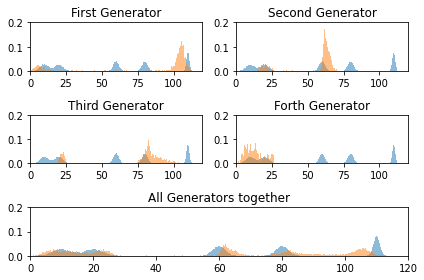

Epoch 146/200
390/390 [==============================] - 10s 27ms/step - g_loss0: 0.7181 - g_loss1: 0.6661 - g_loss2: 0.7327 - g_loss3: 0.6990 - d_loss: 0.9512
Epoch 147/200
390/390 [==============================] - 11s 28ms/step - g_loss0: 0.7138 - g_loss1: 0.6683 - g_loss2: 0.7375 - g_loss3: 0.7003 - d_loss: 0.9544
Epoch 148/200
390/390 [==============================] - 11s 29ms/step - g_loss0: 0.7145 - g_loss1: 0.6685 - g_loss2: 0.7348 - g_loss3: 0.6971 - d_loss: 0.9433
Epoch 149/200
390/390 [==============================] - 12s 30ms/step - g_loss0: 0.7115 - g_loss1: 0.6680 - g_loss2: 0.7333 - g_loss3: 0.6960 - d_loss: 0.9436
Epoch 150/200
390/390 [==============================] - 11s 28ms/step - g_loss0: 0.7068 - g_loss1: 0.6707 - g_loss2: 0.7345 - g_loss3: 0.6970 - d_loss: 0.9428


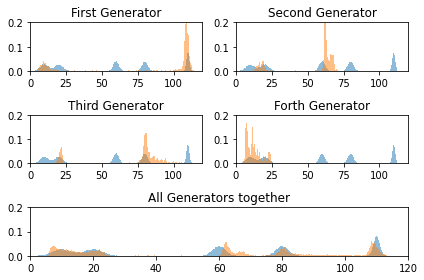

Epoch 151/200
390/390 [==============================] - 10s 27ms/step - g_loss0: 0.7076 - g_loss1: 0.6699 - g_loss2: 0.7352 - g_loss3: 0.7025 - d_loss: 0.9389
Epoch 152/200
390/390 [==============================] - 11s 28ms/step - g_loss0: 0.7021 - g_loss1: 0.6764 - g_loss2: 0.7341 - g_loss3: 0.6964 - d_loss: 0.9347
Epoch 153/200
390/390 [==============================] - 11s 28ms/step - g_loss0: 0.7044 - g_loss1: 0.6749 - g_loss2: 0.7383 - g_loss3: 0.6934 - d_loss: 0.9346
Epoch 154/200
390/390 [==============================] - 12s 31ms/step - g_loss0: 0.6976 - g_loss1: 0.6740 - g_loss2: 0.7380 - g_loss3: 0.7010 - d_loss: 0.9283
Epoch 155/200
390/390 [==============================] - 11s 28ms/step - g_loss0: 0.6895 - g_loss1: 0.6749 - g_loss2: 0.7421 - g_loss3: 0.7055 - d_loss: 0.9415


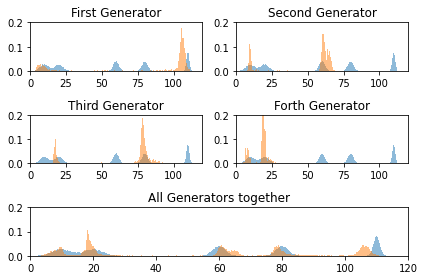

Epoch 156/200
390/390 [==============================] - 11s 28ms/step - g_loss0: 0.6163 - g_loss1: 0.7733 - g_loss2: 0.7892 - g_loss3: 0.7223 - d_loss: 1.0150
Epoch 157/200
390/390 [==============================] - 11s 28ms/step - g_loss0: 0.6391 - g_loss1: 0.8215 - g_loss2: 0.7949 - g_loss3: 0.6981 - d_loss: 1.0200
Epoch 158/200
390/390 [==============================] - 11s 29ms/step - g_loss0: 0.6497 - g_loss1: 0.7876 - g_loss2: 0.7718 - g_loss3: 0.6978 - d_loss: 1.0305
Epoch 159/200
390/390 [==============================] - 12s 30ms/step - g_loss0: 0.6500 - g_loss1: 0.7716 - g_loss2: 0.7614 - g_loss3: 0.7096 - d_loss: 1.0374
Epoch 160/200
390/390 [==============================] - 11s 29ms/step - g_loss0: 0.6760 - g_loss1: 0.7658 - g_loss2: 0.7404 - g_loss3: 0.7154 - d_loss: 1.0446


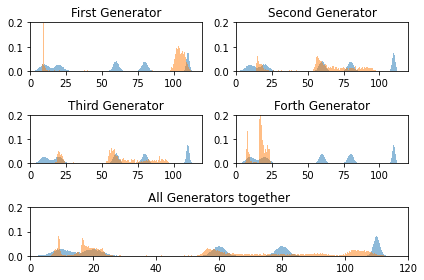

Epoch 161/200
390/390 [==============================] - 11s 27ms/step - g_loss0: 0.6609 - g_loss1: 0.7544 - g_loss2: 0.7479 - g_loss3: 0.7058 - d_loss: 1.0468
Epoch 162/200
390/390 [==============================] - 11s 29ms/step - g_loss0: 0.6619 - g_loss1: 0.7500 - g_loss2: 0.7534 - g_loss3: 0.6984 - d_loss: 1.0542
Epoch 163/200
390/390 [==============================] - 11s 28ms/step - g_loss0: 0.6728 - g_loss1: 0.7453 - g_loss2: 0.7460 - g_loss3: 0.6903 - d_loss: 1.0355
Epoch 164/200
390/390 [==============================] - 12s 31ms/step - g_loss0: 0.6841 - g_loss1: 0.7386 - g_loss2: 0.7363 - g_loss3: 0.6926 - d_loss: 1.0241
Epoch 165/200
390/390 [==============================] - 11s 28ms/step - g_loss0: 0.6820 - g_loss1: 0.7389 - g_loss2: 0.7406 - g_loss3: 0.6891 - d_loss: 1.0239


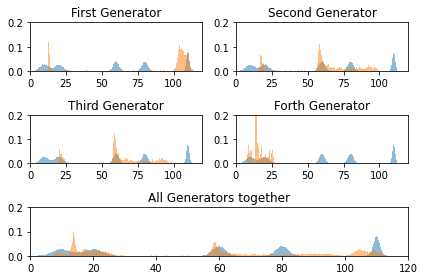

Epoch 166/200
390/390 [==============================] - 11s 28ms/step - g_loss0: 0.6820 - g_loss1: 0.7412 - g_loss2: 0.7416 - g_loss3: 0.6828 - d_loss: 1.0179
Epoch 167/200
390/390 [==============================] - 11s 29ms/step - g_loss0: 0.6808 - g_loss1: 0.7428 - g_loss2: 0.7408 - g_loss3: 0.6807 - d_loss: 1.0103
Epoch 168/200
390/390 [==============================] - 11s 29ms/step - g_loss0: 0.6831 - g_loss1: 0.7415 - g_loss2: 0.7354 - g_loss3: 0.6836 - d_loss: 1.0162
Epoch 169/200
390/390 [==============================] - 12s 31ms/step - g_loss0: 0.6971 - g_loss1: 0.7366 - g_loss2: 0.7206 - g_loss3: 0.6965 - d_loss: 1.0133
Epoch 170/200
390/390 [==============================] - 11s 29ms/step - g_loss0: 0.6764 - g_loss1: 0.7432 - g_loss2: 0.7424 - g_loss3: 0.6902 - d_loss: 1.0156


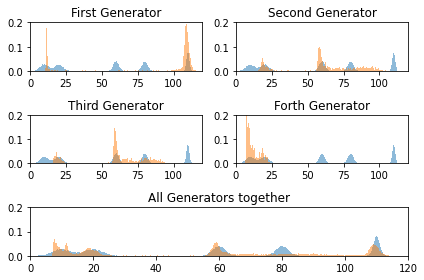

Epoch 171/200
390/390 [==============================] - 11s 27ms/step - g_loss0: 0.6672 - g_loss1: 0.7456 - g_loss2: 0.7436 - g_loss3: 0.6938 - d_loss: 1.0410
Epoch 172/200
390/390 [==============================] - 12s 30ms/step - g_loss0: 0.6814 - g_loss1: 0.7430 - g_loss2: 0.7410 - g_loss3: 0.6921 - d_loss: 1.0443
Epoch 173/200
390/390 [==============================] - 11s 28ms/step - g_loss0: 0.6897 - g_loss1: 0.7415 - g_loss2: 0.7322 - g_loss3: 0.6924 - d_loss: 1.0257
Epoch 174/200
390/390 [==============================] - 12s 32ms/step - g_loss0: 0.6851 - g_loss1: 0.7402 - g_loss2: 0.7293 - g_loss3: 0.6957 - d_loss: 1.0347
Epoch 175/200
390/390 [==============================] - 11s 28ms/step - g_loss0: 0.6880 - g_loss1: 0.7415 - g_loss2: 0.7291 - g_loss3: 0.7005 - d_loss: 1.0313


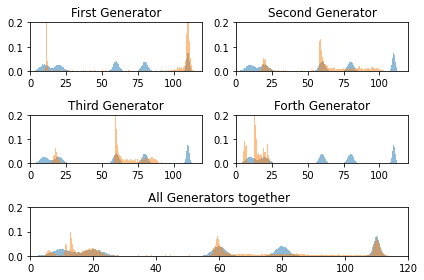

Epoch 176/200
390/390 [==============================] - 11s 29ms/step - g_loss0: 0.6864 - g_loss1: 0.7444 - g_loss2: 0.7293 - g_loss3: 0.6990 - d_loss: 1.0238
Epoch 177/200
390/390 [==============================] - 11s 29ms/step - g_loss0: 0.6780 - g_loss1: 0.7468 - g_loss2: 0.7356 - g_loss3: 0.6972 - d_loss: 1.0182
Epoch 178/200
390/390 [==============================] - 11s 29ms/step - g_loss0: 0.6797 - g_loss1: 0.7471 - g_loss2: 0.7347 - g_loss3: 0.6923 - d_loss: 1.0076
Epoch 179/200
390/390 [==============================] - 12s 32ms/step - g_loss0: 0.6759 - g_loss1: 0.7451 - g_loss2: 0.7369 - g_loss3: 0.6967 - d_loss: 1.0094
Epoch 180/200
390/390 [==============================] - 12s 30ms/step - g_loss0: 0.6800 - g_loss1: 0.7398 - g_loss2: 0.7334 - g_loss3: 0.7029 - d_loss: 1.0131


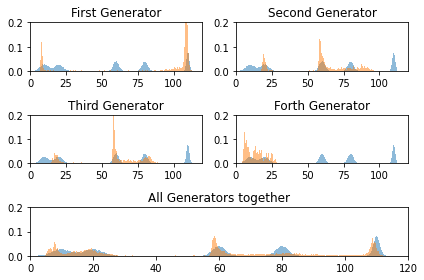

Epoch 181/200
390/390 [==============================] - 11s 28ms/step - g_loss0: 0.6673 - g_loss1: 0.7479 - g_loss2: 0.7402 - g_loss3: 0.7005 - d_loss: 1.0175
Epoch 182/200
390/390 [==============================] - 12s 30ms/step - g_loss0: 0.6461 - g_loss1: 0.7575 - g_loss2: 0.7495 - g_loss3: 0.7057 - d_loss: 1.0201
Epoch 183/200
390/390 [==============================] - 11s 29ms/step - g_loss0: 0.6677 - g_loss1: 0.7604 - g_loss2: 0.7541 - g_loss3: 0.6809 - d_loss: 1.0228
Epoch 184/200
390/390 [==============================] - 13s 33ms/step - g_loss0: 0.6701 - g_loss1: 0.7594 - g_loss2: 0.7527 - g_loss3: 0.6865 - d_loss: 1.0214
Epoch 185/200
390/390 [==============================] - 11s 28ms/step - g_loss0: 0.6606 - g_loss1: 0.7597 - g_loss2: 0.7540 - g_loss3: 0.6880 - d_loss: 1.0115


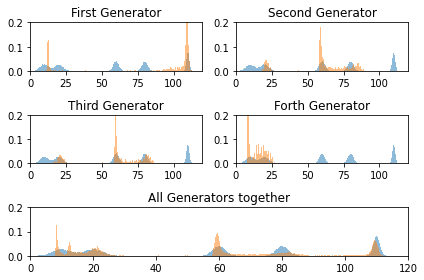

Epoch 186/200
390/390 [==============================] - 11s 29ms/step - g_loss0: 0.6578 - g_loss1: 0.7606 - g_loss2: 0.7547 - g_loss3: 0.6857 - d_loss: 1.0102
Epoch 187/200
390/390 [==============================] - 12s 30ms/step - g_loss0: 0.6571 - g_loss1: 0.7584 - g_loss2: 0.7521 - g_loss3: 0.6898 - d_loss: 1.0142
Epoch 188/200
390/390 [==============================] - 12s 30ms/step - g_loss0: 0.6508 - g_loss1: 0.7619 - g_loss2: 0.7594 - g_loss3: 0.6882 - d_loss: 1.0120
Epoch 189/200
390/390 [==============================] - 12s 32ms/step - g_loss0: 0.6471 - g_loss1: 0.7611 - g_loss2: 0.7601 - g_loss3: 0.6892 - d_loss: 1.0069
Epoch 190/200
390/390 [==============================] - 12s 30ms/step - g_loss0: 0.6536 - g_loss1: 0.7692 - g_loss2: 0.7631 - g_loss3: 0.6758 - d_loss: 1.0155


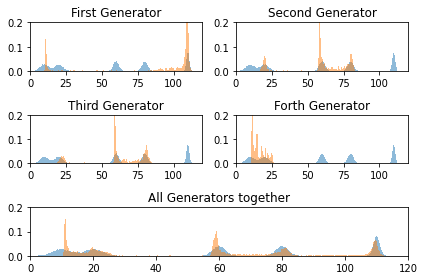

Epoch 191/200
390/390 [==============================] - 11s 28ms/step - g_loss0: 0.6543 - g_loss1: 0.7722 - g_loss2: 0.7676 - g_loss3: 0.6735 - d_loss: 1.0154
Epoch 192/200
390/390 [==============================] - 12s 30ms/step - g_loss0: 0.6547 - g_loss1: 0.7712 - g_loss2: 0.7660 - g_loss3: 0.6730 - d_loss: 1.0092
Epoch 193/200
390/390 [==============================] - 12s 30ms/step - g_loss0: 0.6563 - g_loss1: 0.7724 - g_loss2: 0.7664 - g_loss3: 0.6722 - d_loss: 1.0053
Epoch 194/200
390/390 [==============================] - 13s 33ms/step - g_loss0: 0.6563 - g_loss1: 0.7718 - g_loss2: 0.7677 - g_loss3: 0.6696 - d_loss: 1.0072
Epoch 195/200
390/390 [==============================] - 11s 29ms/step - g_loss0: 0.6532 - g_loss1: 0.7707 - g_loss2: 0.7638 - g_loss3: 0.6725 - d_loss: 1.0126


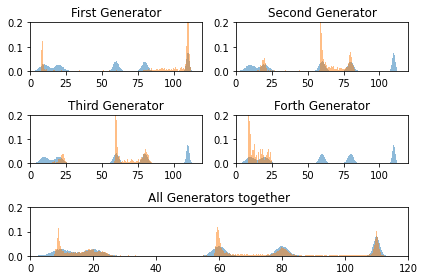

Epoch 196/200
390/390 [==============================] - 12s 30ms/step - g_loss0: 0.6554 - g_loss1: 0.7715 - g_loss2: 0.7659 - g_loss3: 0.6695 - d_loss: 1.0078
Epoch 197/200
390/390 [==============================] - 12s 30ms/step - g_loss0: 0.6639 - g_loss1: 0.7685 - g_loss2: 0.7634 - g_loss3: 0.6706 - d_loss: 1.0067
Epoch 198/200
390/390 [==============================] - 12s 30ms/step - g_loss0: 0.6631 - g_loss1: 0.7668 - g_loss2: 0.7613 - g_loss3: 0.6633 - d_loss: 1.0080
Epoch 199/200
390/390 [==============================] - 13s 33ms/step - g_loss0: 0.6591 - g_loss1: 0.7698 - g_loss2: 0.7668 - g_loss3: 0.6675 - d_loss: 1.0138
Epoch 200/200
390/390 [==============================] - 12s 31ms/step - g_loss0: 0.6591 - g_loss1: 0.7687 - g_loss2: 0.7653 - g_loss3: 0.6710 - d_loss: 1.0119


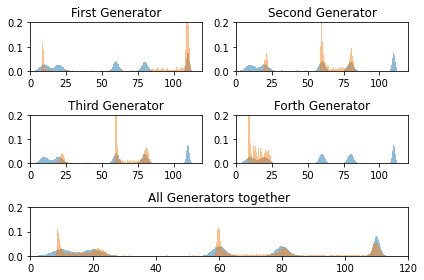

In [ ]:
# Loading data
data = dataset1_func(size_dataset)
# Changing numpy dataset to tf.DATASET type and Shuffling dataset for training
dataset = tf.data.Dataset.from_tensor_slices(data) 
dataset = dataset.repeat().shuffle(10 * size_dataset, reshuffle_each_iteration=True).batch(n_Gen * batch_size, drop_remainder=True)

# Creating Discriminator and Generator
discriminator = define_discriminator(n_Gen, h_Dim)
generators = define_generators(n_Gen, latent_dim, h_Dim)

# creating MADGAN
madgan = MADGAN(discriminator = discriminator, generators = generators, 
                latent_dim = latent_dim, n_Gen = n_Gen)

madgan.compile(
    d_optimizer = Adam(learning_rate=1e-4, beta_1=0.5),
    g_optimizer = [Adam(learning_rate=1e-4, beta_1=0.5) for g in range(n_Gen)],
    d_loss_fn = CategoricalCrossentropy(),
    g_loss_fn = Generators_loss_function
)

# saved model directory
checkpoint_filepath = f'/content/drive/MyDrive/{dir_name}/checkpoint'

# callbacks are functions that run at end of each epoch
my_callbacks = [
    # This callback is for ploting generators' output every epoch
    GANMonitor2(dataset = data, plot_freq = 5, num_samples = 10000, latent_dim = latent_dim, n_Gen = n_Gen, dir_name = dir_name),
    # This callback is for Saving the model every 15 epochs
    tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath, save_freq = 20, save_weights_only=True),
]

# # Loading previous saved model for resume training
# if os.path.exists(checkpoint_filepath):
#     madgan.load_weights(checkpoint_filepath)

# train the model
madgan.fit(dataset, epochs = 200, initial_epoch = 0, steps_per_epoch = steps_per_epoch, verbose = 1, callbacks = my_callbacks)

Epoch 201/300
390/390 [==============================] - 13s 29ms/step - g_loss0: 0.6737 - g_loss1: 0.7711 - g_loss2: 0.7636 - g_loss3: 0.6598 - d_loss: 1.0219
Epoch 202/300
390/390 [==============================] - 11s 28ms/step - g_loss0: 0.6715 - g_loss1: 0.7678 - g_loss2: 0.7641 - g_loss3: 0.6581 - d_loss: 1.0142
Epoch 203/300
390/390 [==============================] - 12s 32ms/step - g_loss0: 0.6620 - g_loss1: 0.7683 - g_loss2: 0.7637 - g_loss3: 0.6625 - d_loss: 1.0128
Epoch 204/300
390/390 [==============================] - 11s 28ms/step - g_loss0: 0.6671 - g_loss1: 0.7666 - g_loss2: 0.7632 - g_loss3: 0.6600 - d_loss: 1.0161
Epoch 205/300
390/390 [==============================] - 11s 29ms/step - g_loss0: 0.6605 - g_loss1: 0.7655 - g_loss2: 0.7626 - g_loss3: 0.6654 - d_loss: 1.0153


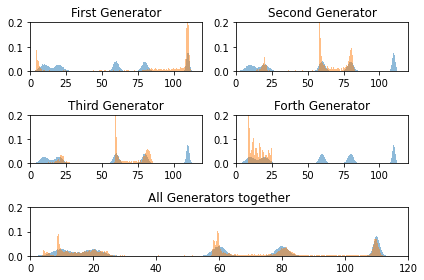

Epoch 206/300
390/390 [==============================] - 11s 27ms/step - g_loss0: 0.6652 - g_loss1: 0.7658 - g_loss2: 0.7627 - g_loss3: 0.6632 - d_loss: 1.0092
Epoch 207/300
390/390 [==============================] - 12s 30ms/step - g_loss0: 0.6676 - g_loss1: 0.7628 - g_loss2: 0.7613 - g_loss3: 0.6673 - d_loss: 1.0311
Epoch 208/300
390/390 [==============================] - 11s 29ms/step - g_loss0: 0.6646 - g_loss1: 0.7667 - g_loss2: 0.7618 - g_loss3: 0.6668 - d_loss: 1.0178
Epoch 209/300
390/390 [==============================] - 13s 33ms/step - g_loss0: 0.6659 - g_loss1: 0.7653 - g_loss2: 0.7617 - g_loss3: 0.6656 - d_loss: 1.0169
Epoch 210/300
390/390 [==============================] - 11s 28ms/step - g_loss0: 0.6679 - g_loss1: 0.7632 - g_loss2: 0.7591 - g_loss3: 0.6684 - d_loss: 1.0155


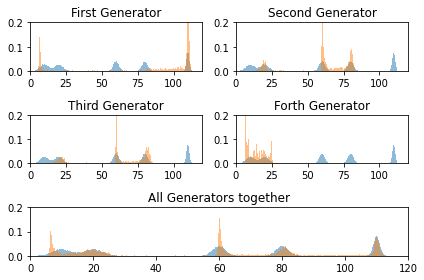

Epoch 211/300
390/390 [==============================] - 11s 29ms/step - g_loss0: 0.6574 - g_loss1: 0.7615 - g_loss2: 0.7588 - g_loss3: 0.6746 - d_loss: 1.0137
Epoch 212/300
390/390 [==============================] - 11s 29ms/step - g_loss0: 0.6690 - g_loss1: 0.7614 - g_loss2: 0.7580 - g_loss3: 0.6672 - d_loss: 1.0141
Epoch 213/300
390/390 [==============================] - 12s 30ms/step - g_loss0: 0.6659 - g_loss1: 0.7610 - g_loss2: 0.7599 - g_loss3: 0.6729 - d_loss: 1.0320
Epoch 214/300
390/390 [==============================] - 12s 32ms/step - g_loss0: 0.6666 - g_loss1: 0.7625 - g_loss2: 0.7591 - g_loss3: 0.6719 - d_loss: 1.0153
Epoch 215/300
390/390 [==============================] - 11s 29ms/step - g_loss0: 0.6591 - g_loss1: 0.7642 - g_loss2: 0.7628 - g_loss3: 0.6723 - d_loss: 1.0178


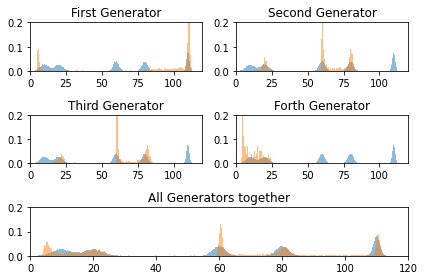

Epoch 216/300
390/390 [==============================] - 11s 28ms/step - g_loss0: 0.6675 - g_loss1: 0.7621 - g_loss2: 0.7575 - g_loss3: 0.6706 - d_loss: 1.0140
Epoch 217/300
390/390 [==============================] - 12s 30ms/step - g_loss0: 0.6662 - g_loss1: 0.7614 - g_loss2: 0.7591 - g_loss3: 0.6667 - d_loss: 1.0139
Epoch 218/300
390/390 [==============================] - 11s 29ms/step - g_loss0: 0.6663 - g_loss1: 0.7612 - g_loss2: 0.7576 - g_loss3: 0.6716 - d_loss: 1.0275
Epoch 219/300
390/390 [==============================] - 13s 33ms/step - g_loss0: 0.6627 - g_loss1: 0.7630 - g_loss2: 0.7600 - g_loss3: 0.6751 - d_loss: 1.0225
Epoch 220/300
390/390 [==============================] - 11s 29ms/step - g_loss0: 0.6658 - g_loss1: 0.7602 - g_loss2: 0.7580 - g_loss3: 0.6761 - d_loss: 1.0214


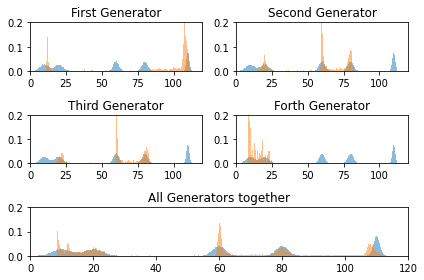

Epoch 221/300
390/390 [==============================] - 11s 29ms/step - g_loss0: 0.6622 - g_loss1: 0.7608 - g_loss2: 0.7579 - g_loss3: 0.6770 - d_loss: 1.0193
Epoch 222/300
390/390 [==============================] - 12s 30ms/step - g_loss0: 0.6659 - g_loss1: 0.7588 - g_loss2: 0.7555 - g_loss3: 0.6762 - d_loss: 1.0199
Epoch 223/300
390/390 [==============================] - 12s 31ms/step - g_loss0: 0.6589 - g_loss1: 0.7562 - g_loss2: 0.7543 - g_loss3: 0.6828 - d_loss: 1.0267
Epoch 224/300
390/390 [==============================] - 12s 32ms/step - g_loss0: 0.6764 - g_loss1: 0.7556 - g_loss2: 0.7545 - g_loss3: 0.6733 - d_loss: 1.0131
Epoch 225/300
390/390 [==============================] - 12s 31ms/step - g_loss0: 0.6641 - g_loss1: 0.7577 - g_loss2: 0.7568 - g_loss3: 0.6755 - d_loss: 1.0216


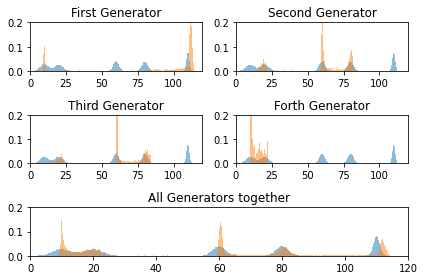

Epoch 226/300
390/390 [==============================] - 11s 29ms/step - g_loss0: 0.6666 - g_loss1: 0.7554 - g_loss2: 0.7524 - g_loss3: 0.6867 - d_loss: 1.0244
Epoch 227/300
390/390 [==============================] - 12s 31ms/step - g_loss0: 0.6665 - g_loss1: 0.7572 - g_loss2: 0.7552 - g_loss3: 0.6796 - d_loss: 1.0205
Epoch 228/300
390/390 [==============================] - 11s 29ms/step - g_loss0: 0.6607 - g_loss1: 0.7589 - g_loss2: 0.7576 - g_loss3: 0.6794 - d_loss: 1.0196
Epoch 229/300
390/390 [==============================] - 13s 33ms/step - g_loss0: 0.6637 - g_loss1: 0.7583 - g_loss2: 0.7568 - g_loss3: 0.6770 - d_loss: 1.0157
Epoch 230/300
390/390 [==============================] - 12s 30ms/step - g_loss0: 0.6517 - g_loss1: 0.7567 - g_loss2: 0.7543 - g_loss3: 0.6851 - d_loss: 1.0231


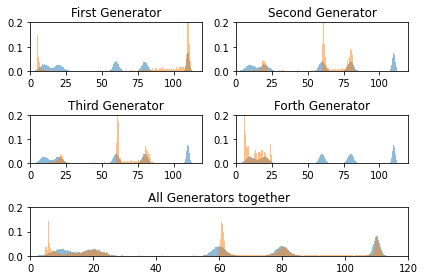

Epoch 231/300
390/390 [==============================] - 12s 30ms/step - g_loss0: 0.6656 - g_loss1: 0.7542 - g_loss2: 0.7518 - g_loss3: 0.6838 - d_loss: 1.0213
Epoch 232/300
390/390 [==============================] - 12s 30ms/step - g_loss0: 0.6603 - g_loss1: 0.7522 - g_loss2: 0.7508 - g_loss3: 0.6884 - d_loss: 1.0291
Epoch 233/300
390/390 [==============================] - 12s 31ms/step - g_loss0: 0.6627 - g_loss1: 0.7516 - g_loss2: 0.7509 - g_loss3: 0.6916 - d_loss: 1.0229
Epoch 234/300
390/390 [==============================] - 13s 32ms/step - g_loss0: 0.6589 - g_loss1: 0.7516 - g_loss2: 0.7510 - g_loss3: 0.6918 - d_loss: 1.0235
Epoch 235/300
390/390 [==============================] - 12s 31ms/step - g_loss0: 0.6664 - g_loss1: 0.7518 - g_loss2: 0.7510 - g_loss3: 0.6877 - d_loss: 1.0127


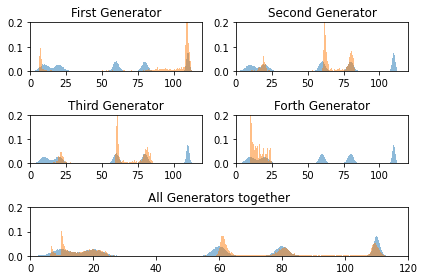

Epoch 236/300
390/390 [==============================] - 11s 29ms/step - g_loss0: 0.6671 - g_loss1: 0.7497 - g_loss2: 0.7493 - g_loss3: 0.6897 - d_loss: 1.0254
Epoch 237/300
390/390 [==============================] - 12s 32ms/step - g_loss0: 0.6681 - g_loss1: 0.7509 - g_loss2: 0.7506 - g_loss3: 0.6901 - d_loss: 1.0263
Epoch 238/300
390/390 [==============================] - 12s 30ms/step - g_loss0: 0.6694 - g_loss1: 0.7505 - g_loss2: 0.7499 - g_loss3: 0.6873 - d_loss: 1.0198
Epoch 239/300
390/390 [==============================] - 14s 35ms/step - g_loss0: 0.6635 - g_loss1: 0.7530 - g_loss2: 0.7534 - g_loss3: 0.6880 - d_loss: 1.0213
Epoch 240/300
390/390 [==============================] - 12s 30ms/step - g_loss0: 0.6650 - g_loss1: 0.7528 - g_loss2: 0.7522 - g_loss3: 0.6878 - d_loss: 1.0201


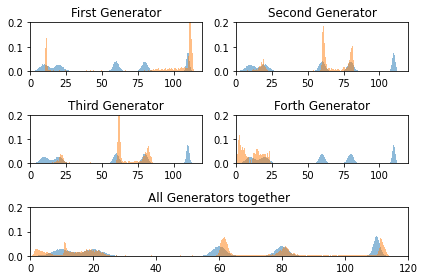

Epoch 241/300
390/390 [==============================] - 12s 31ms/step - g_loss0: 0.6691 - g_loss1: 0.7518 - g_loss2: 0.7507 - g_loss3: 0.6869 - d_loss: 1.0157
Epoch 242/300
390/390 [==============================] - 12s 31ms/step - g_loss0: 0.6529 - g_loss1: 0.7539 - g_loss2: 0.7548 - g_loss3: 0.6950 - d_loss: 1.0248
Epoch 243/300
390/390 [==============================] - 12s 31ms/step - g_loss0: 0.6716 - g_loss1: 0.7512 - g_loss2: 0.7515 - g_loss3: 0.6863 - d_loss: 1.0170
Epoch 244/300
390/390 [==============================] - 13s 34ms/step - g_loss0: 0.6743 - g_loss1: 0.7500 - g_loss2: 0.7501 - g_loss3: 0.6875 - d_loss: 1.0340
Epoch 245/300
390/390 [==============================] - 12s 31ms/step - g_loss0: 0.6685 - g_loss1: 0.7485 - g_loss2: 0.7480 - g_loss3: 0.6943 - d_loss: 1.0241


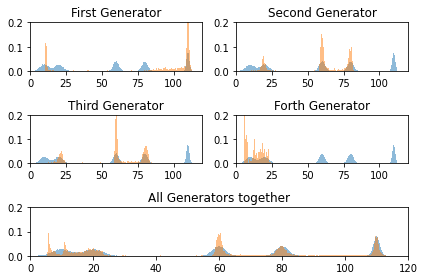

Epoch 246/300
390/390 [==============================] - 12s 30ms/step - g_loss0: 0.6717 - g_loss1: 0.7504 - g_loss2: 0.7503 - g_loss3: 0.6877 - d_loss: 1.0155
Epoch 247/300
390/390 [==============================] - 12s 32ms/step - g_loss0: 0.6663 - g_loss1: 0.7515 - g_loss2: 0.7513 - g_loss3: 0.6879 - d_loss: 1.0192
Epoch 248/300
390/390 [==============================] - 12s 30ms/step - g_loss0: 0.6734 - g_loss1: 0.7536 - g_loss2: 0.7537 - g_loss3: 0.6895 - d_loss: 1.0183
Epoch 249/300
390/390 [==============================] - 12s 31ms/step - g_loss0: 0.6845 - g_loss1: 0.7508 - g_loss2: 0.7514 - g_loss3: 0.6858 - d_loss: 1.0199
Epoch 250/300
390/390 [==============================] - 13s 33ms/step - g_loss0: 0.6865 - g_loss1: 0.7470 - g_loss2: 0.7479 - g_loss3: 0.6910 - d_loss: 1.0296


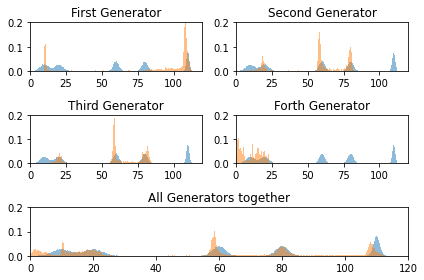

Epoch 251/300
390/390 [==============================] - 12s 31ms/step - g_loss0: 0.6851 - g_loss1: 0.7461 - g_loss2: 0.7475 - g_loss3: 0.6911 - d_loss: 1.0195
Epoch 252/300
390/390 [==============================] - 12s 31ms/step - g_loss0: 0.6812 - g_loss1: 0.7520 - g_loss2: 0.7526 - g_loss3: 0.6855 - d_loss: 1.0199
Epoch 253/300
390/390 [==============================] - 13s 32ms/step - g_loss0: 0.6858 - g_loss1: 0.7548 - g_loss2: 0.7546 - g_loss3: 0.6819 - d_loss: 1.0102
Epoch 254/300
390/390 [==============================] - 13s 34ms/step - g_loss0: 0.6900 - g_loss1: 0.7515 - g_loss2: 0.7518 - g_loss3: 0.6844 - d_loss: 1.0169
Epoch 255/300
390/390 [==============================] - 13s 33ms/step - g_loss0: 0.6866 - g_loss1: 0.7454 - g_loss2: 0.7454 - g_loss3: 0.6916 - d_loss: 1.0133


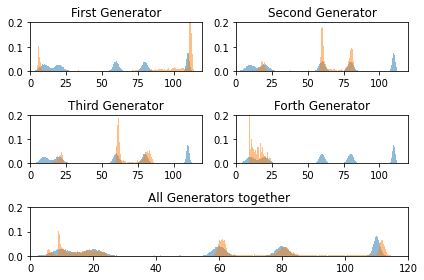

Epoch 256/300
390/390 [==============================] - 12s 31ms/step - g_loss0: 0.6921 - g_loss1: 0.7470 - g_loss2: 0.7473 - g_loss3: 0.6878 - d_loss: 1.0180
Epoch 257/300
390/390 [==============================] - 13s 33ms/step - g_loss0: 0.6889 - g_loss1: 0.7425 - g_loss2: 0.7450 - g_loss3: 0.6954 - d_loss: 1.0336
Epoch 258/300
390/390 [==============================] - 13s 32ms/step - g_loss0: 0.6842 - g_loss1: 0.7481 - g_loss2: 0.7492 - g_loss3: 0.6901 - d_loss: 1.0169
Epoch 259/300
390/390 [==============================] - 14s 36ms/step - g_loss0: 0.6809 - g_loss1: 0.7505 - g_loss2: 0.7514 - g_loss3: 0.6936 - d_loss: 1.0191
Epoch 260/300
390/390 [==============================] - 12s 31ms/step - g_loss0: 0.6909 - g_loss1: 0.7480 - g_loss2: 0.7496 - g_loss3: 0.6876 - d_loss: 1.0191


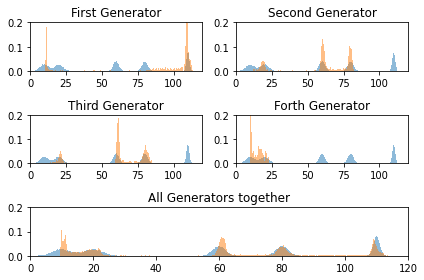

Epoch 261/300
390/390 [==============================] - 13s 33ms/step - g_loss0: 0.6953 - g_loss1: 0.7393 - g_loss2: 0.7404 - g_loss3: 0.6973 - d_loss: 1.0347
Epoch 262/300
390/390 [==============================] - 13s 32ms/step - g_loss0: 0.6891 - g_loss1: 0.7421 - g_loss2: 0.7439 - g_loss3: 0.6940 - d_loss: 1.0245
Epoch 263/300
390/390 [==============================] - 13s 33ms/step - g_loss0: 0.6862 - g_loss1: 0.7471 - g_loss2: 0.7492 - g_loss3: 0.6913 - d_loss: 1.0203
Epoch 264/300
390/390 [==============================] - 14s 35ms/step - g_loss0: 0.6907 - g_loss1: 0.7509 - g_loss2: 0.7525 - g_loss3: 0.6846 - d_loss: 1.0133
Epoch 265/300
390/390 [==============================] - 13s 33ms/step - g_loss0: 0.6951 - g_loss1: 0.7385 - g_loss2: 0.7401 - g_loss3: 0.6991 - d_loss: 1.0320


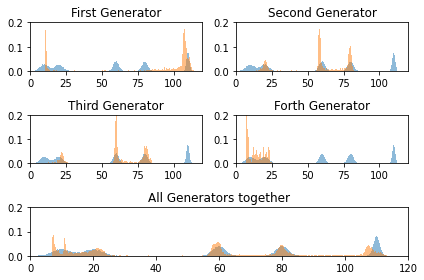

Epoch 266/300
390/390 [==============================] - 13s 32ms/step - g_loss0: 0.6925 - g_loss1: 0.7408 - g_loss2: 0.7432 - g_loss3: 0.6971 - d_loss: 1.0248
Epoch 267/300
390/390 [==============================] - 13s 33ms/step - g_loss0: 0.6901 - g_loss1: 0.7443 - g_loss2: 0.7454 - g_loss3: 0.6893 - d_loss: 1.0211
Epoch 268/300
390/390 [==============================] - 13s 33ms/step - g_loss0: 0.6900 - g_loss1: 0.7448 - g_loss2: 0.7456 - g_loss3: 0.6925 - d_loss: 1.0240
Epoch 269/300
390/390 [==============================] - 14s 36ms/step - g_loss0: 0.6876 - g_loss1: 0.7441 - g_loss2: 0.7469 - g_loss3: 0.6904 - d_loss: 1.0174
Epoch 270/300
390/390 [==============================] - 13s 33ms/step - g_loss0: 0.6941 - g_loss1: 0.7457 - g_loss2: 0.7465 - g_loss3: 0.6908 - d_loss: 1.0211


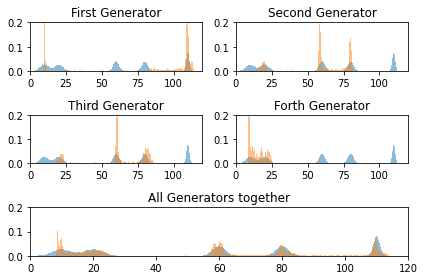

Epoch 271/300
390/390 [==============================] - 13s 33ms/step - g_loss0: 0.6900 - g_loss1: 0.7379 - g_loss2: 0.7400 - g_loss3: 0.6960 - d_loss: 1.0215
Epoch 272/300
390/390 [==============================] - 13s 33ms/step - g_loss0: 0.6820 - g_loss1: 0.7425 - g_loss2: 0.7446 - g_loss3: 0.6985 - d_loss: 1.0173
Epoch 273/300
390/390 [==============================] - 13s 33ms/step - g_loss0: 0.6883 - g_loss1: 0.7431 - g_loss2: 0.7454 - g_loss3: 0.6989 - d_loss: 1.0319
Epoch 274/300
390/390 [==============================] - 14s 35ms/step - g_loss0: 0.6896 - g_loss1: 0.7440 - g_loss2: 0.7457 - g_loss3: 0.6932 - d_loss: 1.0271
Epoch 275/300
390/390 [==============================] - 13s 33ms/step - g_loss0: 0.6776 - g_loss1: 0.7470 - g_loss2: 0.7493 - g_loss3: 0.6919 - d_loss: 1.0184


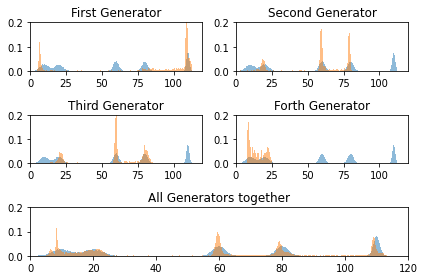

Epoch 276/300
390/390 [==============================] - 12s 31ms/step - g_loss0: 0.6907 - g_loss1: 0.7427 - g_loss2: 0.7434 - g_loss3: 0.6940 - d_loss: 1.0211
Epoch 277/300
390/390 [==============================] - 13s 34ms/step - g_loss0: 0.6879 - g_loss1: 0.7426 - g_loss2: 0.7451 - g_loss3: 0.6918 - d_loss: 1.0102
Epoch 278/300
390/390 [==============================] - 13s 33ms/step - g_loss0: 0.6914 - g_loss1: 0.7434 - g_loss2: 0.7455 - g_loss3: 0.6876 - d_loss: 1.0308
Epoch 279/300
390/390 [==============================] - 14s 37ms/step - g_loss0: 0.6832 - g_loss1: 0.7462 - g_loss2: 0.7478 - g_loss3: 0.6967 - d_loss: 1.0269
Epoch 280/300
390/390 [==============================] - 12s 32ms/step - g_loss0: 0.6792 - g_loss1: 0.7498 - g_loss2: 0.7500 - g_loss3: 0.6952 - d_loss: 1.0138


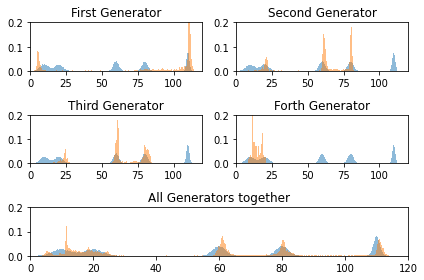

Epoch 281/300
390/390 [==============================] - 13s 34ms/step - g_loss0: 0.6916 - g_loss1: 0.7423 - g_loss2: 0.7407 - g_loss3: 0.6981 - d_loss: 1.0102
Epoch 282/300
390/390 [==============================] - 13s 32ms/step - g_loss0: 0.6917 - g_loss1: 0.7459 - g_loss2: 0.7473 - g_loss3: 0.6898 - d_loss: 1.0101
Epoch 283/300
390/390 [==============================] - 13s 35ms/step - g_loss0: 0.6952 - g_loss1: 0.7370 - g_loss2: 0.7377 - g_loss3: 0.7006 - d_loss: 1.0330
Epoch 284/300
390/390 [==============================] - 14s 36ms/step - g_loss0: 0.6908 - g_loss1: 0.7416 - g_loss2: 0.7402 - g_loss3: 0.7008 - d_loss: 1.0410
Epoch 285/300
390/390 [==============================] - 13s 34ms/step - g_loss0: 0.6853 - g_loss1: 0.7409 - g_loss2: 0.7432 - g_loss3: 0.7024 - d_loss: 1.0195


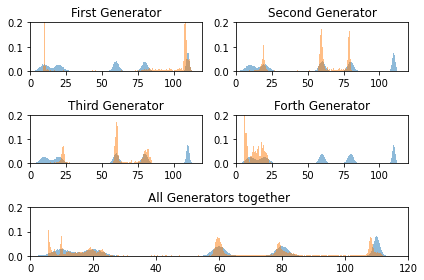

Epoch 286/300
390/390 [==============================] - 13s 33ms/step - g_loss0: 0.6826 - g_loss1: 0.7418 - g_loss2: 0.7441 - g_loss3: 0.7069 - d_loss: 1.0277
Epoch 287/300
390/390 [==============================] - 13s 34ms/step - g_loss0: 0.6836 - g_loss1: 0.7456 - g_loss2: 0.7471 - g_loss3: 0.6990 - d_loss: 1.0078
Epoch 288/300
390/390 [==============================] - 13s 33ms/step - g_loss0: 0.6868 - g_loss1: 0.7496 - g_loss2: 0.7517 - g_loss3: 0.6969 - d_loss: 1.0072
Epoch 289/300
390/390 [==============================] - 15s 38ms/step - g_loss0: 0.6815 - g_loss1: 0.7448 - g_loss2: 0.7470 - g_loss3: 0.7062 - d_loss: 1.0185
Epoch 290/300
390/390 [==============================] - 13s 33ms/step - g_loss0: 0.6864 - g_loss1: 0.7460 - g_loss2: 0.7469 - g_loss3: 0.7047 - d_loss: 1.0205


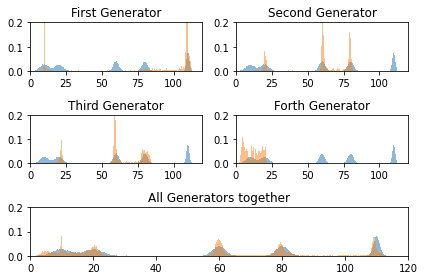

Epoch 291/300
390/390 [==============================] - 13s 35ms/step - g_loss0: 0.6887 - g_loss1: 0.7455 - g_loss2: 0.7487 - g_loss3: 0.6993 - d_loss: 1.0299
Epoch 292/300
390/390 [==============================] - 13s 33ms/step - g_loss0: 0.6800 - g_loss1: 0.7442 - g_loss2: 0.7457 - g_loss3: 0.7131 - d_loss: 1.0278
Epoch 293/300
390/390 [==============================] - 13s 34ms/step - g_loss0: 0.6923 - g_loss1: 0.7429 - g_loss2: 0.7455 - g_loss3: 0.6976 - d_loss: 1.0121
Epoch 294/300
390/390 [==============================] - 14s 37ms/step - g_loss0: 0.6821 - g_loss1: 0.7507 - g_loss2: 0.7530 - g_loss3: 0.6898 - d_loss: 1.0276
Epoch 295/300
390/390 [==============================] - 13s 34ms/step - g_loss0: 0.6911 - g_loss1: 0.7419 - g_loss2: 0.7445 - g_loss3: 0.7039 - d_loss: 1.0277


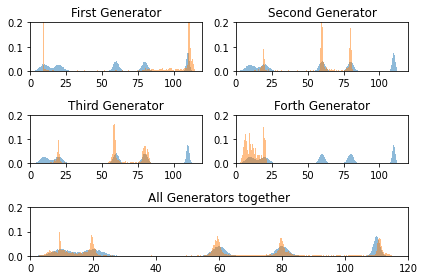

Epoch 296/300
390/390 [==============================] - 13s 34ms/step - g_loss0: 0.6771 - g_loss1: 0.7453 - g_loss2: 0.7493 - g_loss3: 0.7130 - d_loss: 1.0519
Epoch 297/300
390/390 [==============================] - 13s 34ms/step - g_loss0: 0.6912 - g_loss1: 0.7362 - g_loss2: 0.7380 - g_loss3: 0.7058 - d_loss: 1.0283
Epoch 298/300
390/390 [==============================] - 13s 34ms/step - g_loss0: 0.6872 - g_loss1: 0.7377 - g_loss2: 0.7407 - g_loss3: 0.7010 - d_loss: 1.0310
Epoch 299/300
390/390 [==============================] - 15s 38ms/step - g_loss0: 0.6987 - g_loss1: 0.7528 - g_loss2: 0.7329 - g_loss3: 0.6974 - d_loss: 1.0384
Epoch 300/300
390/390 [==============================] - 13s 33ms/step - g_loss0: 0.6851 - g_loss1: 0.7466 - g_loss2: 0.7356 - g_loss3: 0.6971 - d_loss: 1.0393


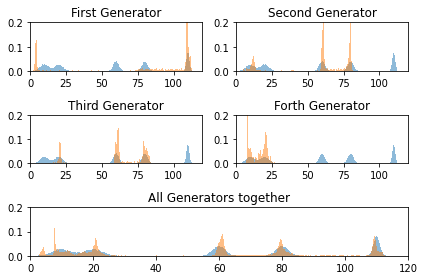

In [ ]:
madgan.fit(dataset, epochs = 300, initial_epoch = 200, steps_per_epoch = steps_per_epoch, verbose = 1, callbacks = my_callbacks)

Epoch 301/400
390/390 [==============================] - 15s 35ms/step - g_loss0: 0.7053 - g_loss1: 0.7499 - g_loss2: 0.7397 - g_loss3: 0.6770 - d_loss: 1.0285
Epoch 302/400
390/390 [==============================] - 13s 33ms/step - g_loss0: 0.7065 - g_loss1: 0.7466 - g_loss2: 0.7389 - g_loss3: 0.6799 - d_loss: 1.0387
Epoch 303/400
390/390 [==============================] - 14s 35ms/step - g_loss0: 0.6996 - g_loss1: 0.7458 - g_loss2: 0.7360 - g_loss3: 0.6890 - d_loss: 1.0373
Epoch 304/400
390/390 [==============================] - 14s 36ms/step - g_loss0: 0.6970 - g_loss1: 0.7411 - g_loss2: 0.7406 - g_loss3: 0.6949 - d_loss: 1.0333
Epoch 305/400
390/390 [==============================] - 14s 35ms/step - g_loss0: 0.6954 - g_loss1: 0.7451 - g_loss2: 0.7381 - g_loss3: 0.6975 - d_loss: 1.0395


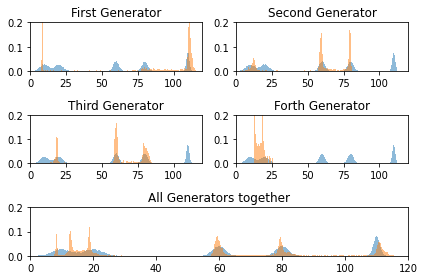

Epoch 306/400
390/390 [==============================] - 13s 33ms/step - g_loss0: 0.6920 - g_loss1: 0.7447 - g_loss2: 0.7397 - g_loss3: 0.6934 - d_loss: 1.0329
Epoch 307/400
390/390 [==============================] - 13s 34ms/step - g_loss0: 0.6902 - g_loss1: 0.7459 - g_loss2: 0.7464 - g_loss3: 0.6965 - d_loss: 1.0334
Epoch 308/400
390/390 [==============================] - 13s 33ms/step - g_loss0: 0.6922 - g_loss1: 0.7465 - g_loss2: 0.7474 - g_loss3: 0.6980 - d_loss: 1.0443
Epoch 309/400
390/390 [==============================] - 15s 38ms/step - g_loss0: 0.6905 - g_loss1: 0.7427 - g_loss2: 0.7433 - g_loss3: 0.6961 - d_loss: 1.0326
Epoch 310/400
390/390 [==============================] - 13s 34ms/step - g_loss0: 0.6816 - g_loss1: 0.7452 - g_loss2: 0.7458 - g_loss3: 0.6982 - d_loss: 1.0346


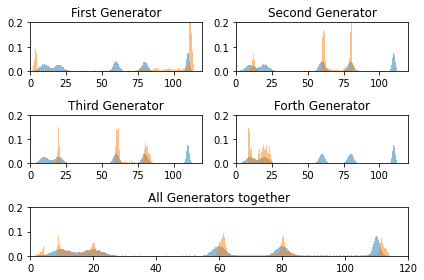

Epoch 311/400
390/390 [==============================] - 13s 35ms/step - g_loss0: 0.6961 - g_loss1: 0.7455 - g_loss2: 0.7382 - g_loss3: 0.6964 - d_loss: 1.0315
Epoch 312/400
390/390 [==============================] - 13s 34ms/step - g_loss0: 0.6918 - g_loss1: 0.7472 - g_loss2: 0.7466 - g_loss3: 0.6971 - d_loss: 1.0406
Epoch 313/400
390/390 [==============================] - 14s 35ms/step - g_loss0: 0.6855 - g_loss1: 0.7480 - g_loss2: 0.7516 - g_loss3: 0.6981 - d_loss: 1.0301
Epoch 314/400
390/390 [==============================] - 14s 37ms/step - g_loss0: 0.6876 - g_loss1: 0.7469 - g_loss2: 0.7502 - g_loss3: 0.6993 - d_loss: 1.0267
Epoch 315/400
390/390 [==============================] - 14s 36ms/step - g_loss0: 0.6813 - g_loss1: 0.7430 - g_loss2: 0.7447 - g_loss3: 0.7178 - d_loss: 1.0196


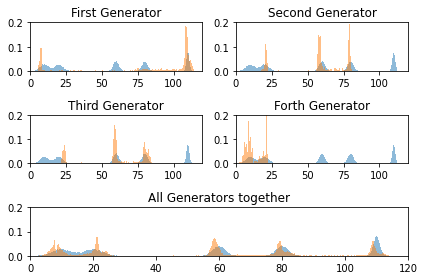

Epoch 316/400
390/390 [==============================] - 13s 33ms/step - g_loss0: 0.6839 - g_loss1: 0.7441 - g_loss2: 0.7494 - g_loss3: 0.7016 - d_loss: 1.0375
Epoch 317/400
390/390 [==============================] - 14s 36ms/step - g_loss0: 0.6818 - g_loss1: 0.7225 - g_loss2: 0.7203 - g_loss3: 0.7458 - d_loss: 1.0749
Epoch 318/400
390/390 [==============================] - 13s 34ms/step - g_loss0: 0.6979 - g_loss1: 0.7501 - g_loss2: 0.7352 - g_loss3: 0.6980 - d_loss: 1.0371
Epoch 319/400
390/390 [==============================] - 15s 38ms/step - g_loss0: 0.6877 - g_loss1: 0.7423 - g_loss2: 0.7392 - g_loss3: 0.7019 - d_loss: 1.0285
Epoch 320/400
390/390 [==============================] - 13s 35ms/step - g_loss0: 0.6787 - g_loss1: 0.7399 - g_loss2: 0.7392 - g_loss3: 0.7100 - d_loss: 1.0352


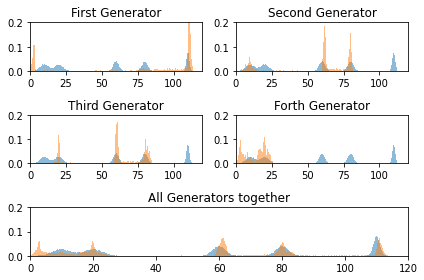

Epoch 321/400
390/390 [==============================] - 14s 35ms/step - g_loss0: 0.6950 - g_loss1: 0.7462 - g_loss2: 0.7408 - g_loss3: 0.6953 - d_loss: 1.0325
Epoch 322/400
390/390 [==============================] - 13s 34ms/step - g_loss0: 0.6890 - g_loss1: 0.7461 - g_loss2: 0.7451 - g_loss3: 0.6978 - d_loss: 1.0456
Epoch 323/400
390/390 [==============================] - 14s 36ms/step - g_loss0: 0.6863 - g_loss1: 0.7401 - g_loss2: 0.7431 - g_loss3: 0.7058 - d_loss: 1.0375
Epoch 324/400
390/390 [==============================] - 15s 37ms/step - g_loss0: 0.6955 - g_loss1: 0.7482 - g_loss2: 0.7448 - g_loss3: 0.6984 - d_loss: 1.0387
Epoch 325/400
390/390 [==============================] - 14s 36ms/step - g_loss0: 0.6898 - g_loss1: 0.7413 - g_loss2: 0.7387 - g_loss3: 0.7035 - d_loss: 1.0399


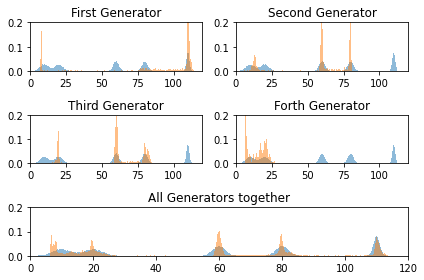

Epoch 326/400
390/390 [==============================] - 13s 33ms/step - g_loss0: 0.6889 - g_loss1: 0.7420 - g_loss2: 0.7424 - g_loss3: 0.7061 - d_loss: 1.0289
Epoch 327/400
390/390 [==============================] - 14s 36ms/step - g_loss0: 0.6906 - g_loss1: 0.7451 - g_loss2: 0.7389 - g_loss3: 0.7099 - d_loss: 1.0478
Epoch 328/400
390/390 [==============================] - 13s 34ms/step - g_loss0: 0.6649 - g_loss1: 0.7611 - g_loss2: 0.7583 - g_loss3: 0.6958 - d_loss: 1.0516
Epoch 329/400
390/390 [==============================] - 15s 39ms/step - g_loss0: 0.6821 - g_loss1: 0.7500 - g_loss2: 0.7478 - g_loss3: 0.7104 - d_loss: 1.0378
Epoch 330/400
390/390 [==============================] - 14s 35ms/step - g_loss0: 0.6867 - g_loss1: 0.7461 - g_loss2: 0.7477 - g_loss3: 0.7017 - d_loss: 1.0231


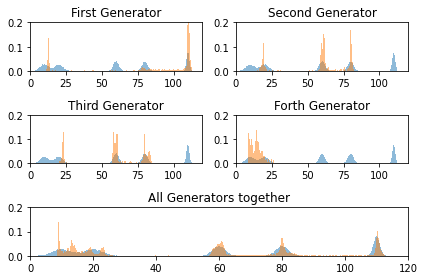

Epoch 331/400
390/390 [==============================] - 14s 36ms/step - g_loss0: 0.6876 - g_loss1: 0.7423 - g_loss2: 0.7445 - g_loss3: 0.7090 - d_loss: 1.0142
Epoch 332/400
390/390 [==============================] - 14s 35ms/step - g_loss0: 0.6884 - g_loss1: 0.7456 - g_loss2: 0.7512 - g_loss3: 0.7059 - d_loss: 1.0203
Epoch 333/400
390/390 [==============================] - 14s 36ms/step - g_loss0: 0.6880 - g_loss1: 0.7408 - g_loss2: 0.7453 - g_loss3: 0.7111 - d_loss: 1.0727
Epoch 334/400
390/390 [==============================] - 15s 38ms/step - g_loss0: 0.6827 - g_loss1: 0.7481 - g_loss2: 0.7514 - g_loss3: 0.6980 - d_loss: 1.0386
Epoch 335/400
390/390 [==============================] - 14s 37ms/step - g_loss0: 0.6852 - g_loss1: 0.7625 - g_loss2: 0.7600 - g_loss3: 0.6858 - d_loss: 1.0642


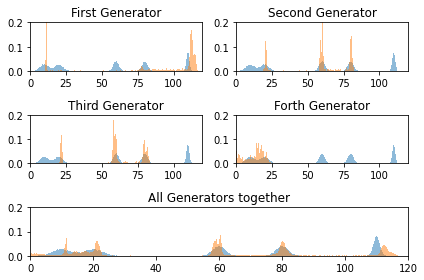

Epoch 336/400
390/390 [==============================] - 14s 35ms/step - g_loss0: 0.6788 - g_loss1: 0.7569 - g_loss2: 0.7584 - g_loss3: 0.7062 - d_loss: 1.0277
Epoch 337/400
390/390 [==============================] - 15s 37ms/step - g_loss0: 0.6788 - g_loss1: 0.7511 - g_loss2: 0.7537 - g_loss3: 0.7218 - d_loss: 1.0377
Epoch 338/400
390/390 [==============================] - 14s 35ms/step - g_loss0: 0.6874 - g_loss1: 0.7396 - g_loss2: 0.7407 - g_loss3: 0.7061 - d_loss: 1.0605
Epoch 339/400
390/390 [==============================] - 16s 40ms/step - g_loss0: 0.6973 - g_loss1: 0.7465 - g_loss2: 0.7465 - g_loss3: 0.6880 - d_loss: 1.0375
Epoch 340/400
390/390 [==============================] - 14s 35ms/step - g_loss0: 0.6968 - g_loss1: 0.7523 - g_loss2: 0.7525 - g_loss3: 0.6717 - d_loss: 1.0442


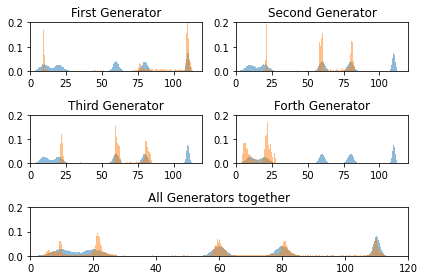

Epoch 341/400
390/390 [==============================] - 14s 36ms/step - g_loss0: 0.6770 - g_loss1: 0.7563 - g_loss2: 0.7597 - g_loss3: 0.6972 - d_loss: 1.0440
Epoch 342/400
390/390 [==============================] - 14s 35ms/step - g_loss0: 0.6855 - g_loss1: 0.7479 - g_loss2: 0.7499 - g_loss3: 0.7090 - d_loss: 1.0420
Epoch 343/400
390/390 [==============================] - 15s 38ms/step - g_loss0: 0.6894 - g_loss1: 0.7427 - g_loss2: 0.7445 - g_loss3: 0.7116 - d_loss: 1.0297
Epoch 344/400
390/390 [==============================] - 15s 39ms/step - g_loss0: 0.6896 - g_loss1: 0.7441 - g_loss2: 0.7468 - g_loss3: 0.7047 - d_loss: 1.0285
Epoch 345/400
390/390 [==============================] - 15s 38ms/step - g_loss0: 0.6832 - g_loss1: 0.7514 - g_loss2: 0.7542 - g_loss3: 0.6991 - d_loss: 1.0458


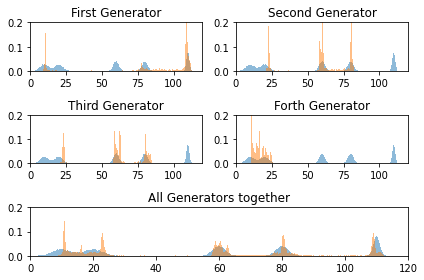

Epoch 346/400
390/390 [==============================] - 14s 36ms/step - g_loss0: 0.6787 - g_loss1: 0.7625 - g_loss2: 0.7646 - g_loss3: 0.6866 - d_loss: 1.0338
Epoch 347/400
390/390 [==============================] - 15s 38ms/step - g_loss0: 0.6871 - g_loss1: 0.7453 - g_loss2: 0.7473 - g_loss3: 0.7055 - d_loss: 1.0304
Epoch 348/400
390/390 [==============================] - 14s 37ms/step - g_loss0: 0.6858 - g_loss1: 0.7455 - g_loss2: 0.7502 - g_loss3: 0.6991 - d_loss: 1.0373
Epoch 349/400
390/390 [==============================] - 16s 40ms/step - g_loss0: 0.6893 - g_loss1: 0.7443 - g_loss2: 0.7438 - g_loss3: 0.7139 - d_loss: 1.0614
Epoch 350/400
390/390 [==============================] - 14s 37ms/step - g_loss0: 0.6960 - g_loss1: 0.7538 - g_loss2: 0.7535 - g_loss3: 0.6903 - d_loss: 1.0249


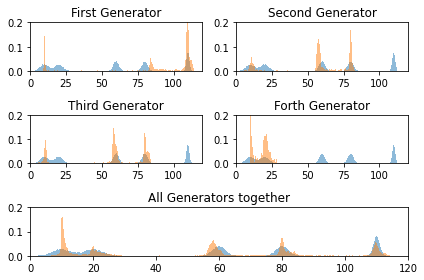

Epoch 351/400
390/390 [==============================] - 14s 37ms/step - g_loss0: 0.7110 - g_loss1: 0.7558 - g_loss2: 0.7577 - g_loss3: 0.6712 - d_loss: 1.0473
Epoch 352/400
390/390 [==============================] - 14s 36ms/step - g_loss0: 0.6968 - g_loss1: 0.7483 - g_loss2: 0.7484 - g_loss3: 0.6906 - d_loss: 1.0352
Epoch 353/400
390/390 [==============================] - 15s 38ms/step - g_loss0: 0.7011 - g_loss1: 0.7480 - g_loss2: 0.7489 - g_loss3: 0.6840 - d_loss: 1.0302
Epoch 354/400
390/390 [==============================] - 15s 40ms/step - g_loss0: 0.6868 - g_loss1: 0.7535 - g_loss2: 0.7538 - g_loss3: 0.7116 - d_loss: 1.0517
Epoch 355/400
390/390 [==============================] - 15s 38ms/step - g_loss0: 0.6840 - g_loss1: 0.7518 - g_loss2: 0.7530 - g_loss3: 0.7069 - d_loss: 1.0484


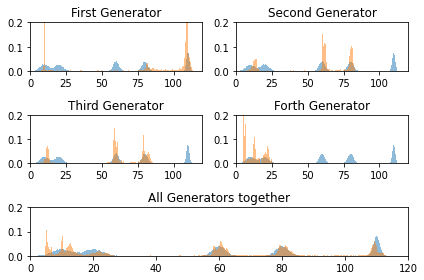

Epoch 356/400
390/390 [==============================] - 14s 36ms/step - g_loss0: 0.7000 - g_loss1: 0.7510 - g_loss2: 0.7484 - g_loss3: 0.6927 - d_loss: 1.0573
Epoch 357/400
390/390 [==============================] - 15s 38ms/step - g_loss0: 0.7005 - g_loss1: 0.7581 - g_loss2: 0.7571 - g_loss3: 0.6863 - d_loss: 1.0412
Epoch 358/400
390/390 [==============================] - 14s 37ms/step - g_loss0: 0.6847 - g_loss1: 0.7502 - g_loss2: 0.7506 - g_loss3: 0.6984 - d_loss: 1.0800
Epoch 359/400
390/390 [==============================] - 16s 41ms/step - g_loss0: 0.6888 - g_loss1: 0.7505 - g_loss2: 0.7511 - g_loss3: 0.6948 - d_loss: 1.0347
Epoch 360/400
390/390 [==============================] - 14s 37ms/step - g_loss0: 0.6904 - g_loss1: 0.7470 - g_loss2: 0.7486 - g_loss3: 0.7018 - d_loss: 1.0288


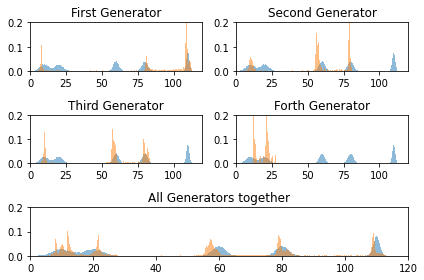

Epoch 361/400
390/390 [==============================] - 15s 38ms/step - g_loss0: 0.6960 - g_loss1: 0.7468 - g_loss2: 0.7491 - g_loss3: 0.6974 - d_loss: 1.0260
Epoch 362/400
390/390 [==============================] - 14s 37ms/step - g_loss0: 0.6986 - g_loss1: 0.7500 - g_loss2: 0.7507 - g_loss3: 0.6859 - d_loss: 1.0643
Epoch 363/400
390/390 [==============================] - 15s 38ms/step - g_loss0: 0.6814 - g_loss1: 0.7492 - g_loss2: 0.7502 - g_loss3: 0.7067 - d_loss: 1.0659
Epoch 364/400
390/390 [==============================] - 15s 39ms/step - g_loss0: 0.6915 - g_loss1: 0.7477 - g_loss2: 0.7487 - g_loss3: 0.6949 - d_loss: 1.0463
Epoch 365/400
390/390 [==============================] - 15s 39ms/step - g_loss0: 0.6821 - g_loss1: 0.7448 - g_loss2: 0.7452 - g_loss3: 0.7189 - d_loss: 1.0693


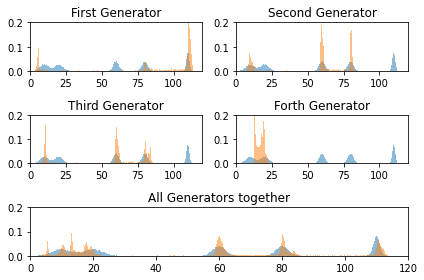

Epoch 366/400
390/390 [==============================] - 14s 36ms/step - g_loss0: 0.6860 - g_loss1: 0.7473 - g_loss2: 0.7488 - g_loss3: 0.6981 - d_loss: 1.0325
Epoch 367/400
390/390 [==============================] - 16s 40ms/step - g_loss0: 0.6912 - g_loss1: 0.7472 - g_loss2: 0.7471 - g_loss3: 0.7070 - d_loss: 1.0395
Epoch 368/400
390/390 [==============================] - 14s 37ms/step - g_loss0: 0.6882 - g_loss1: 0.7462 - g_loss2: 0.7446 - g_loss3: 0.7215 - d_loss: 1.0723
Epoch 369/400
390/390 [==============================] - 16s 42ms/step - g_loss0: 0.7038 - g_loss1: 0.7504 - g_loss2: 0.7510 - g_loss3: 0.6995 - d_loss: 1.0384
Epoch 370/400
390/390 [==============================] - 15s 38ms/step - g_loss0: 0.6859 - g_loss1: 0.7506 - g_loss2: 0.7501 - g_loss3: 0.7106 - d_loss: 1.0763


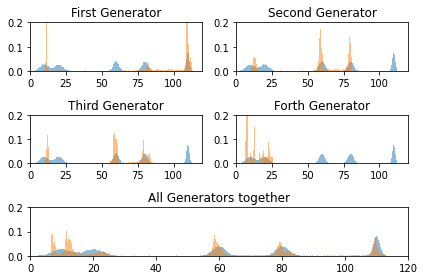

Epoch 371/400
390/390 [==============================] - 15s 38ms/step - g_loss0: 0.6930 - g_loss1: 0.7441 - g_loss2: 0.7423 - g_loss3: 0.7085 - d_loss: 1.0564
Epoch 372/400
390/390 [==============================] - 15s 38ms/step - g_loss0: 0.6889 - g_loss1: 0.7492 - g_loss2: 0.7518 - g_loss3: 0.7026 - d_loss: 1.0644
Epoch 373/400
390/390 [==============================] - 15s 39ms/step - g_loss0: 0.6886 - g_loss1: 0.7407 - g_loss2: 0.7402 - g_loss3: 0.7217 - d_loss: 1.0679
Epoch 374/400
390/390 [==============================] - 16s 40ms/step - g_loss0: 0.6922 - g_loss1: 0.7449 - g_loss2: 0.7455 - g_loss3: 0.7014 - d_loss: 1.0297
Epoch 375/400
390/390 [==============================] - 16s 40ms/step - g_loss0: 0.6744 - g_loss1: 0.7496 - g_loss2: 0.7518 - g_loss3: 0.7246 - d_loss: 1.0706


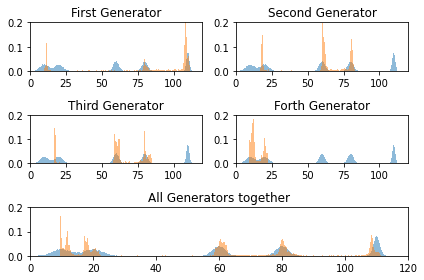

Epoch 376/400
390/390 [==============================] - 14s 37ms/step - g_loss0: 0.6683 - g_loss1: 0.7412 - g_loss2: 0.7565 - g_loss3: 0.7177 - d_loss: 1.0748
Epoch 377/400
390/390 [==============================] - 15s 40ms/step - g_loss0: 0.6814 - g_loss1: 0.7434 - g_loss2: 0.7445 - g_loss3: 0.7217 - d_loss: 1.0542
Epoch 378/400
390/390 [==============================] - 15s 39ms/step - g_loss0: 0.6909 - g_loss1: 0.7491 - g_loss2: 0.7506 - g_loss3: 0.7154 - d_loss: 1.0744
Epoch 379/400
390/390 [==============================] - 17s 43ms/step - g_loss0: 0.6679 - g_loss1: 0.7300 - g_loss2: 0.7473 - g_loss3: 0.7320 - d_loss: 1.0649
Epoch 380/400
390/390 [==============================] - 15s 38ms/step - g_loss0: 0.6817 - g_loss1: 0.7432 - g_loss2: 0.7554 - g_loss3: 0.7184 - d_loss: 1.0574


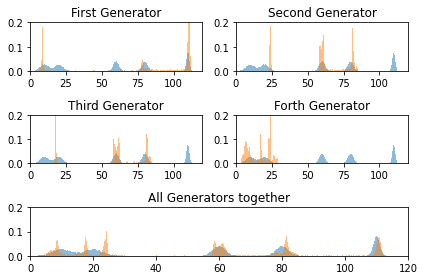

Epoch 381/400
390/390 [==============================] - 16s 40ms/step - g_loss0: 0.6693 - g_loss1: 0.7496 - g_loss2: 0.7434 - g_loss3: 0.7254 - d_loss: 1.0614
Epoch 382/400
390/390 [==============================] - 15s 39ms/step - g_loss0: 0.6831 - g_loss1: 0.7417 - g_loss2: 0.7454 - g_loss3: 0.7303 - d_loss: 1.0622
Epoch 383/400
390/390 [==============================] - 16s 40ms/step - g_loss0: 0.6775 - g_loss1: 0.7459 - g_loss2: 0.7466 - g_loss3: 0.7190 - d_loss: 1.0563
Epoch 384/400
390/390 [==============================] - 17s 43ms/step - g_loss0: 0.6809 - g_loss1: 0.7354 - g_loss2: 0.7438 - g_loss3: 0.7379 - d_loss: 1.0597
Epoch 385/400
390/390 [==============================] - 16s 41ms/step - g_loss0: 0.6740 - g_loss1: 0.7398 - g_loss2: 0.7387 - g_loss3: 0.7244 - d_loss: 1.0486


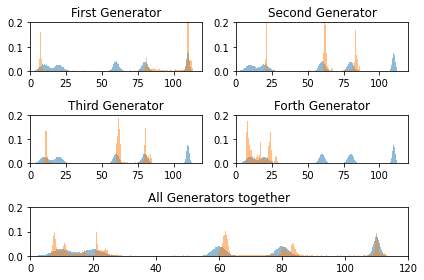

Epoch 386/400
390/390 [==============================] - 15s 39ms/step - g_loss0: 0.6794 - g_loss1: 0.7321 - g_loss2: 0.7518 - g_loss3: 0.7170 - d_loss: 1.0498
Epoch 387/400
390/390 [==============================] - 16s 41ms/step - g_loss0: 0.6806 - g_loss1: 0.7326 - g_loss2: 0.7481 - g_loss3: 0.7198 - d_loss: 1.0575
Epoch 388/400
390/390 [==============================] - 15s 39ms/step - g_loss0: 0.6715 - g_loss1: 0.7332 - g_loss2: 0.7314 - g_loss3: 0.7395 - d_loss: 1.0863
Epoch 389/400
390/390 [==============================] - 17s 43ms/step - g_loss0: 0.6863 - g_loss1: 0.7306 - g_loss2: 0.7486 - g_loss3: 0.7138 - d_loss: 1.0612
Epoch 390/400
390/390 [==============================] - 15s 40ms/step - g_loss0: 0.6715 - g_loss1: 0.7460 - g_loss2: 0.7428 - g_loss3: 0.7246 - d_loss: 1.0544


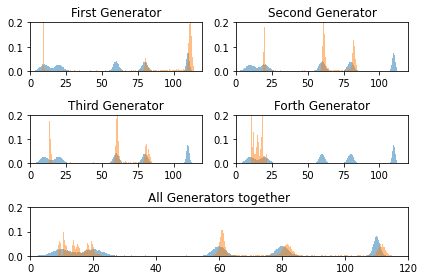

Epoch 391/400
390/390 [==============================] - 16s 40ms/step - g_loss0: 0.6762 - g_loss1: 0.7329 - g_loss2: 0.7333 - g_loss3: 0.7405 - d_loss: 1.0656
Epoch 392/400
390/390 [==============================] - 16s 40ms/step - g_loss0: 0.6846 - g_loss1: 0.7373 - g_loss2: 0.7420 - g_loss3: 0.7239 - d_loss: 1.0659
Epoch 393/400
390/390 [==============================] - 16s 41ms/step - g_loss0: 0.6903 - g_loss1: 0.7402 - g_loss2: 0.7406 - g_loss3: 0.7346 - d_loss: 1.0641
Epoch 394/400
390/390 [==============================] - 17s 43ms/step - g_loss0: 0.6766 - g_loss1: 0.7467 - g_loss2: 0.7498 - g_loss3: 0.7355 - d_loss: 1.0326
Epoch 395/400
390/390 [==============================] - 16s 41ms/step - g_loss0: 0.6879 - g_loss1: 0.7364 - g_loss2: 0.7358 - g_loss3: 0.7310 - d_loss: 1.0337


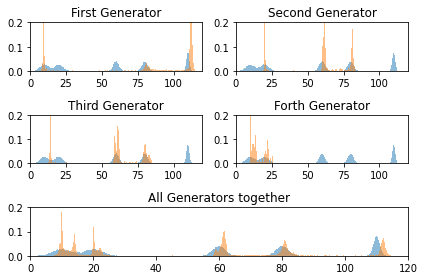

Epoch 396/400
390/390 [==============================] - 16s 40ms/step - g_loss0: 0.6744 - g_loss1: 0.7372 - g_loss2: 0.7345 - g_loss3: 0.7298 - d_loss: 1.0800
Epoch 397/400
390/390 [==============================] - 16s 41ms/step - g_loss0: 0.6719 - g_loss1: 0.7291 - g_loss2: 0.7440 - g_loss3: 0.7363 - d_loss: 1.0562
Epoch 398/400
390/390 [==============================] - 16s 41ms/step - g_loss0: 0.6785 - g_loss1: 0.7321 - g_loss2: 0.7457 - g_loss3: 0.7236 - d_loss: 1.0541
Epoch 399/400
390/390 [==============================] - 17s 44ms/step - g_loss0: 0.6866 - g_loss1: 0.7383 - g_loss2: 0.7495 - g_loss3: 0.7333 - d_loss: 1.0771
Epoch 400/400
390/390 [==============================] - 15s 40ms/step - g_loss0: 0.6699 - g_loss1: 0.7337 - g_loss2: 0.7423 - g_loss3: 0.7318 - d_loss: 1.0757


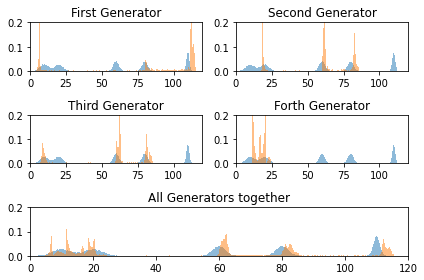

In [ ]:
madgan.fit(dataset, epochs = 400, initial_epoch = 300, steps_per_epoch = steps_per_epoch, verbose = 1, callbacks = my_callbacks)

Epoch 401/500
390/390 [==============================] - 18s 41ms/step - g_loss0: 0.6871 - g_loss1: 0.7368 - g_loss2: 0.7475 - g_loss3: 0.7043 - d_loss: 1.0456
Epoch 402/500
390/390 [==============================] - 16s 41ms/step - g_loss0: 0.6880 - g_loss1: 0.7406 - g_loss2: 0.7467 - g_loss3: 0.7140 - d_loss: 1.0634
Epoch 403/500
390/390 [==============================] - 17s 45ms/step - g_loss0: 0.6860 - g_loss1: 0.7283 - g_loss2: 0.7405 - g_loss3: 0.7189 - d_loss: 1.0611
Epoch 404/500
390/390 [==============================] - 16s 41ms/step - g_loss0: 0.6882 - g_loss1: 0.7307 - g_loss2: 0.7405 - g_loss3: 0.7213 - d_loss: 1.0403
Epoch 405/500
390/390 [==============================] - 16s 41ms/step - g_loss0: 0.6831 - g_loss1: 0.7240 - g_loss2: 0.7468 - g_loss3: 0.7315 - d_loss: 1.0475


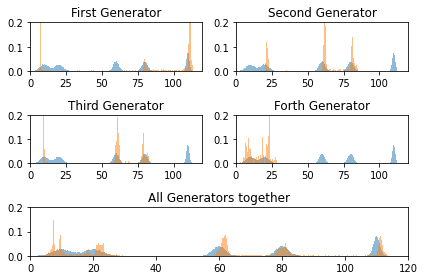

Epoch 406/500
390/390 [==============================] - 15s 40ms/step - g_loss0: 0.6919 - g_loss1: 0.7360 - g_loss2: 0.7421 - g_loss3: 0.7087 - d_loss: 1.0542
Epoch 407/500
390/390 [==============================] - 16s 41ms/step - g_loss0: 0.6859 - g_loss1: 0.7312 - g_loss2: 0.7306 - g_loss3: 0.7274 - d_loss: 1.0807
Epoch 408/500
390/390 [==============================] - 16s 41ms/step - g_loss0: 0.6835 - g_loss1: 0.7423 - g_loss2: 0.7439 - g_loss3: 0.7206 - d_loss: 1.0612
Epoch 409/500
390/390 [==============================] - 18s 45ms/step - g_loss0: 0.6863 - g_loss1: 0.7384 - g_loss2: 0.7442 - g_loss3: 0.7253 - d_loss: 1.0640
Epoch 410/500
390/390 [==============================] - 16s 41ms/step - g_loss0: 0.6784 - g_loss1: 0.7295 - g_loss2: 0.7488 - g_loss3: 0.7238 - d_loss: 1.0673


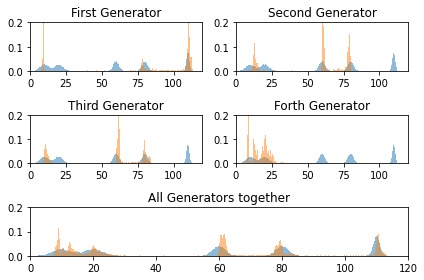

Epoch 411/500
390/390 [==============================] - 16s 41ms/step - g_loss0: 0.6759 - g_loss1: 0.7456 - g_loss2: 0.7472 - g_loss3: 0.7199 - d_loss: 1.0540
Epoch 412/500
390/390 [==============================] - 16s 40ms/step - g_loss0: 0.6714 - g_loss1: 0.7453 - g_loss2: 0.7464 - g_loss3: 0.7233 - d_loss: 1.0640
Epoch 413/500
390/390 [==============================] - 16s 42ms/step - g_loss0: 0.6780 - g_loss1: 0.7447 - g_loss2: 0.7464 - g_loss3: 0.7258 - d_loss: 1.0855
Epoch 414/500
390/390 [==============================] - 17s 44ms/step - g_loss0: 0.6736 - g_loss1: 0.7484 - g_loss2: 0.7530 - g_loss3: 0.7225 - d_loss: 1.0624
Epoch 415/500
390/390 [==============================] - 17s 43ms/step - g_loss0: 0.6731 - g_loss1: 0.7472 - g_loss2: 0.7463 - g_loss3: 0.7197 - d_loss: 1.0476


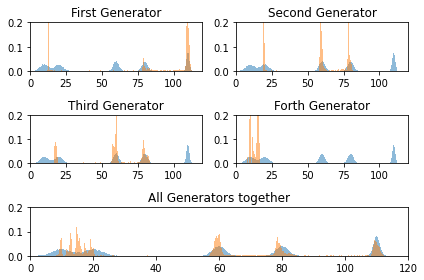

Epoch 416/500
390/390 [==============================] - 15s 40ms/step - g_loss0: 0.6724 - g_loss1: 0.7547 - g_loss2: 0.7592 - g_loss3: 0.7187 - d_loss: 1.0448
Epoch 417/500
390/390 [==============================] - 17s 43ms/step - g_loss0: 0.6706 - g_loss1: 0.7516 - g_loss2: 0.7559 - g_loss3: 0.7113 - d_loss: 1.0497
Epoch 418/500
390/390 [==============================] - 16s 41ms/step - g_loss0: 0.6667 - g_loss1: 0.7602 - g_loss2: 0.7640 - g_loss3: 0.7134 - d_loss: 1.0572
Epoch 419/500
390/390 [==============================] - 17s 45ms/step - g_loss0: 0.6718 - g_loss1: 0.7513 - g_loss2: 0.7551 - g_loss3: 0.7163 - d_loss: 1.0468
Epoch 420/500
390/390 [==============================] - 16s 41ms/step - g_loss0: 0.6682 - g_loss1: 0.7536 - g_loss2: 0.7594 - g_loss3: 0.7077 - d_loss: 1.0439


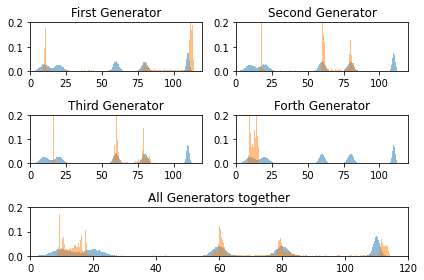

Epoch 421/500
390/390 [==============================] - 16s 42ms/step - g_loss0: 0.6674 - g_loss1: 0.7536 - g_loss2: 0.7582 - g_loss3: 0.7199 - d_loss: 1.0550
Epoch 422/500
390/390 [==============================] - 16s 42ms/step - g_loss0: 0.6720 - g_loss1: 0.7492 - g_loss2: 0.7535 - g_loss3: 0.7199 - d_loss: 1.0516
Epoch 423/500
390/390 [==============================] - 17s 43ms/step - g_loss0: 0.6702 - g_loss1: 0.7554 - g_loss2: 0.7573 - g_loss3: 0.7115 - d_loss: 1.0479
Epoch 424/500
390/390 [==============================] - 17s 44ms/step - g_loss0: 0.6724 - g_loss1: 0.7480 - g_loss2: 0.7512 - g_loss3: 0.7071 - d_loss: 1.0463
Epoch 425/500
390/390 [==============================] - 17s 44ms/step - g_loss0: 0.6693 - g_loss1: 0.7533 - g_loss2: 0.7572 - g_loss3: 0.7204 - d_loss: 1.0610


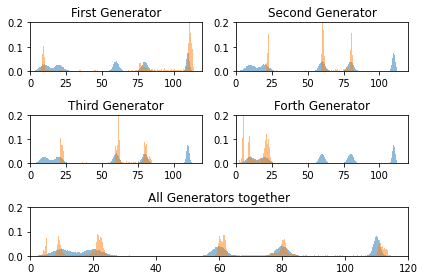

Epoch 426/500
390/390 [==============================] - 16s 41ms/step - g_loss0: 0.6652 - g_loss1: 0.7541 - g_loss2: 0.7561 - g_loss3: 0.7186 - d_loss: 1.0593
Epoch 427/500
390/390 [==============================] - 17s 43ms/step - g_loss0: 0.6764 - g_loss1: 0.7334 - g_loss2: 0.7337 - g_loss3: 0.7226 - d_loss: 1.0969
Epoch 428/500
390/390 [==============================] - 16s 42ms/step - g_loss0: 0.6630 - g_loss1: 0.7482 - g_loss2: 0.7521 - g_loss3: 0.7364 - d_loss: 1.0605
Epoch 429/500
390/390 [==============================] - 18s 45ms/step - g_loss0: 0.6658 - g_loss1: 0.7505 - g_loss2: 0.7514 - g_loss3: 0.7262 - d_loss: 1.0623
Epoch 430/500
390/390 [==============================] - 16s 42ms/step - g_loss0: 0.6795 - g_loss1: 0.7340 - g_loss2: 0.7346 - g_loss3: 0.7300 - d_loss: 1.0896


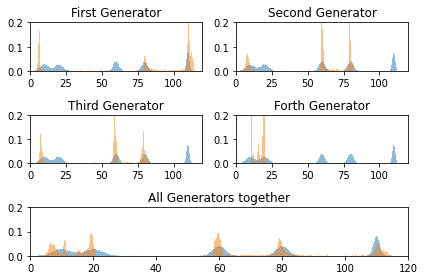

Epoch 431/500
390/390 [==============================] - 17s 43ms/step - g_loss0: 0.6763 - g_loss1: 0.7587 - g_loss2: 0.7633 - g_loss3: 0.7764 - d_loss: 1.1028
Epoch 432/500
390/390 [==============================] - 16s 42ms/step - g_loss0: 0.8036 - g_loss1: 0.7011 - g_loss2: 0.8745 - g_loss3: 0.8560 - d_loss: 1.2610
Epoch 433/500
390/390 [==============================] - 17s 43ms/step - g_loss0: 0.8050 - g_loss1: 0.6581 - g_loss2: 0.7906 - g_loss3: 0.8182 - d_loss: 1.2333
Epoch 434/500
390/390 [==============================] - 17s 45ms/step - g_loss0: 0.8033 - g_loss1: 0.6653 - g_loss2: 0.7889 - g_loss3: 0.8326 - d_loss: 1.2497
Epoch 435/500
390/390 [==============================] - 17s 44ms/step - g_loss0: 0.7760 - g_loss1: 0.6663 - g_loss2: 0.7980 - g_loss3: 0.8263 - d_loss: 1.1825


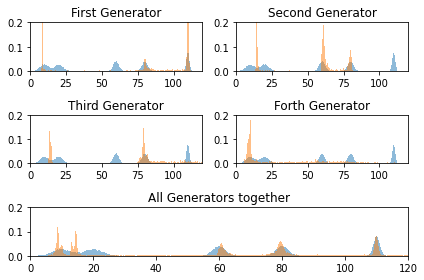

Epoch 436/500
390/390 [==============================] - 16s 41ms/step - g_loss0: 0.7607 - g_loss1: 0.6819 - g_loss2: 0.8111 - g_loss3: 0.8206 - d_loss: 1.1739
Epoch 437/500
390/390 [==============================] - 17s 44ms/step - g_loss0: 0.7623 - g_loss1: 0.6697 - g_loss2: 0.8080 - g_loss3: 0.8476 - d_loss: 1.1766
Epoch 438/500
390/390 [==============================] - 16s 42ms/step - g_loss0: 0.7546 - g_loss1: 0.6764 - g_loss2: 0.7980 - g_loss3: 0.7881 - d_loss: 1.1695
Epoch 439/500
390/390 [==============================] - 18s 47ms/step - g_loss0: 0.7285 - g_loss1: 0.7047 - g_loss2: 0.8075 - g_loss3: 0.8324 - d_loss: 1.1681
Epoch 440/500
390/390 [==============================] - 16s 42ms/step - g_loss0: 0.7581 - g_loss1: 0.6823 - g_loss2: 0.7992 - g_loss3: 0.8358 - d_loss: 1.2063


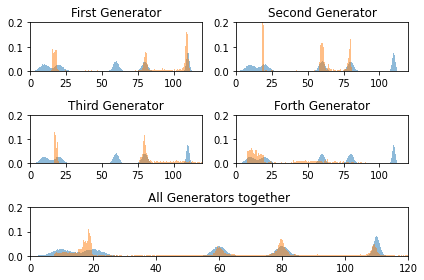

Epoch 441/500
390/390 [==============================] - 17s 44ms/step - g_loss0: 0.7436 - g_loss1: 0.6889 - g_loss2: 0.8044 - g_loss3: 0.7874 - d_loss: 1.1473
Epoch 442/500
390/390 [==============================] - 17s 43ms/step - g_loss0: 0.7472 - g_loss1: 0.6749 - g_loss2: 0.7851 - g_loss3: 0.8024 - d_loss: 1.1822
Epoch 443/500
390/390 [==============================] - 17s 44ms/step - g_loss0: 0.7412 - g_loss1: 0.6927 - g_loss2: 0.7880 - g_loss3: 0.8463 - d_loss: 1.1815
Epoch 444/500
390/390 [==============================] - 18s 47ms/step - g_loss0: 0.7287 - g_loss1: 0.6801 - g_loss2: 0.7905 - g_loss3: 0.8048 - d_loss: 1.1459
Epoch 445/500
390/390 [==============================] - 17s 45ms/step - g_loss0: 0.7412 - g_loss1: 0.6986 - g_loss2: 0.7758 - g_loss3: 0.7923 - d_loss: 1.1607


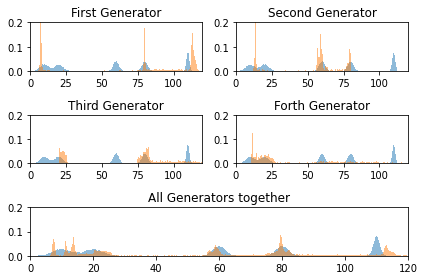

Epoch 446/500
390/390 [==============================] - 17s 43ms/step - g_loss0: 0.7292 - g_loss1: 0.6958 - g_loss2: 0.7987 - g_loss3: 0.8072 - d_loss: 1.1722
Epoch 447/500
390/390 [==============================] - 17s 45ms/step - g_loss0: 0.7310 - g_loss1: 0.6894 - g_loss2: 0.8028 - g_loss3: 0.7814 - d_loss: 1.1322
Epoch 448/500
390/390 [==============================] - 17s 44ms/step - g_loss0: 0.7121 - g_loss1: 0.6879 - g_loss2: 0.7728 - g_loss3: 0.7892 - d_loss: 1.1784
Epoch 449/500
390/390 [==============================] - 18s 45ms/step - g_loss0: 0.7277 - g_loss1: 0.6960 - g_loss2: 0.7932 - g_loss3: 0.7848 - d_loss: 1.1426
Epoch 450/500
390/390 [==============================] - 18s 47ms/step - g_loss0: 0.7199 - g_loss1: 0.7309 - g_loss2: 0.7664 - g_loss3: 0.7709 - d_loss: 1.1222


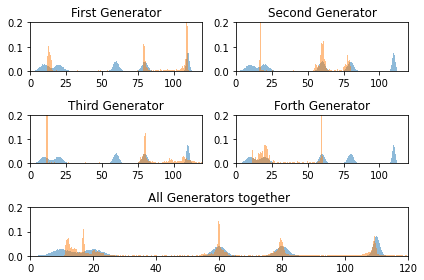

Epoch 451/500
390/390 [==============================] - 17s 45ms/step - g_loss0: 0.7269 - g_loss1: 0.7406 - g_loss2: 0.7609 - g_loss3: 0.8052 - d_loss: 1.1678
Epoch 452/500
390/390 [==============================] - 17s 43ms/step - g_loss0: 0.7099 - g_loss1: 0.7372 - g_loss2: 0.7661 - g_loss3: 0.7672 - d_loss: 1.1161
Epoch 453/500
390/390 [==============================] - 18s 46ms/step - g_loss0: 0.7200 - g_loss1: 0.7321 - g_loss2: 0.7502 - g_loss3: 0.7897 - d_loss: 1.1233
Epoch 454/500
390/390 [==============================] - 18s 46ms/step - g_loss0: 0.7144 - g_loss1: 0.7166 - g_loss2: 0.7508 - g_loss3: 0.7938 - d_loss: 1.1499
Epoch 455/500
390/390 [==============================] - 18s 46ms/step - g_loss0: 0.7202 - g_loss1: 0.7283 - g_loss2: 0.7415 - g_loss3: 0.7897 - d_loss: 1.1163


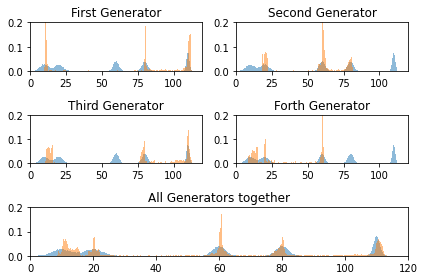

Epoch 456/500
390/390 [==============================] - 17s 43ms/step - g_loss0: 0.7244 - g_loss1: 0.7264 - g_loss2: 0.7340 - g_loss3: 0.7650 - d_loss: 1.1793
Epoch 457/500
390/390 [==============================] - 18s 46ms/step - g_loss0: 0.7377 - g_loss1: 0.7237 - g_loss2: 0.7313 - g_loss3: 0.7884 - d_loss: 1.1441
Epoch 458/500
390/390 [==============================] - 17s 45ms/step - g_loss0: 0.7414 - g_loss1: 0.7173 - g_loss2: 0.7410 - g_loss3: 0.7770 - d_loss: 1.1633
Epoch 459/500
390/390 [==============================] - 19s 48ms/step - g_loss0: 0.7309 - g_loss1: 0.7266 - g_loss2: 0.7322 - g_loss3: 0.7807 - d_loss: 1.1317
Epoch 460/500
390/390 [==============================] - 17s 44ms/step - g_loss0: 0.7236 - g_loss1: 0.7162 - g_loss2: 0.7310 - g_loss3: 0.7741 - d_loss: 1.1475


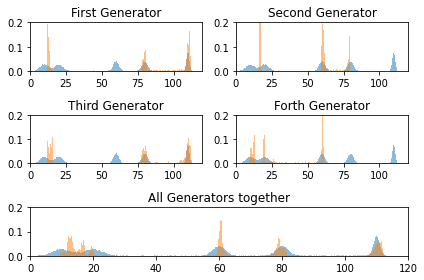

Epoch 461/500
390/390 [==============================] - 18s 45ms/step - g_loss0: 0.7440 - g_loss1: 0.7151 - g_loss2: 0.7377 - g_loss3: 0.7814 - d_loss: 1.1811
Epoch 462/500
390/390 [==============================] - 17s 44ms/step - g_loss0: 0.7087 - g_loss1: 0.7349 - g_loss2: 0.7366 - g_loss3: 0.7932 - d_loss: 1.1385
Epoch 463/500
390/390 [==============================] - 18s 47ms/step - g_loss0: 0.7273 - g_loss1: 0.7143 - g_loss2: 0.7309 - g_loss3: 0.7730 - d_loss: 1.1429
Epoch 464/500
390/390 [==============================] - 18s 47ms/step - g_loss0: 0.7077 - g_loss1: 0.7332 - g_loss2: 0.7391 - g_loss3: 0.7728 - d_loss: 1.1298
Epoch 465/500
390/390 [==============================] - 18s 46ms/step - g_loss0: 0.7488 - g_loss1: 0.6917 - g_loss2: 0.7332 - g_loss3: 0.7621 - d_loss: 1.1412


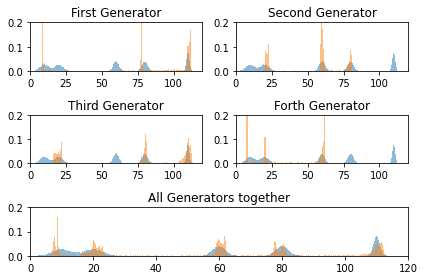

Epoch 466/500
390/390 [==============================] - 17s 44ms/step - g_loss0: 0.7352 - g_loss1: 0.7061 - g_loss2: 0.7310 - g_loss3: 0.7693 - d_loss: 1.1662
Epoch 467/500
390/390 [==============================] - 18s 47ms/step - g_loss0: 0.7238 - g_loss1: 0.7226 - g_loss2: 0.7278 - g_loss3: 0.7798 - d_loss: 1.1629
Epoch 468/500
390/390 [==============================] - 17s 44ms/step - g_loss0: 0.7050 - g_loss1: 0.7244 - g_loss2: 0.7274 - g_loss3: 0.7868 - d_loss: 1.1687
Epoch 469/500
390/390 [==============================] - 19s 50ms/step - g_loss0: 0.7236 - g_loss1: 0.7350 - g_loss2: 0.7322 - g_loss3: 0.7616 - d_loss: 1.1723
Epoch 470/500
390/390 [==============================] - 17s 45ms/step - g_loss0: 0.7234 - g_loss1: 0.7261 - g_loss2: 0.7270 - g_loss3: 0.7694 - d_loss: 1.1732


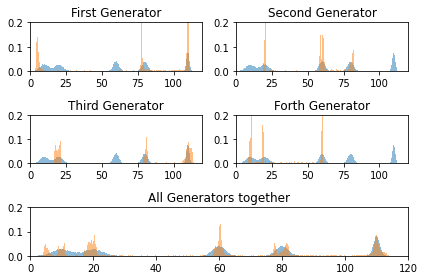

Epoch 471/500
390/390 [==============================] - 18s 46ms/step - g_loss0: 0.7268 - g_loss1: 0.7202 - g_loss2: 0.7281 - g_loss3: 0.7572 - d_loss: 1.1748
Epoch 472/500
390/390 [==============================] - 18s 45ms/step - g_loss0: 0.7241 - g_loss1: 0.7248 - g_loss2: 0.7255 - g_loss3: 0.7693 - d_loss: 1.1611
Epoch 473/500
390/390 [==============================] - 18s 46ms/step - g_loss0: 0.7182 - g_loss1: 0.7186 - g_loss2: 0.7231 - g_loss3: 0.7762 - d_loss: 1.1542
Epoch 474/500
390/390 [==============================] - 18s 47ms/step - g_loss0: 0.7168 - g_loss1: 0.7228 - g_loss2: 0.7255 - g_loss3: 0.7558 - d_loss: 1.1783
Epoch 475/500
390/390 [==============================] - 18s 47ms/step - g_loss0: 0.7344 - g_loss1: 0.7097 - g_loss2: 0.7174 - g_loss3: 0.7633 - d_loss: 1.1602


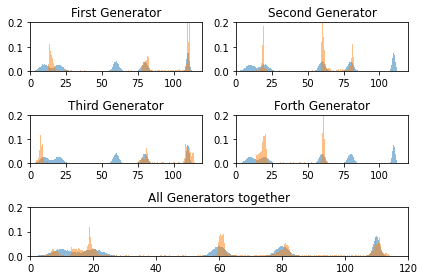

Epoch 476/500
390/390 [==============================] - 17s 44ms/step - g_loss0: 0.7068 - g_loss1: 0.7283 - g_loss2: 0.7140 - g_loss3: 0.7686 - d_loss: 1.1179
Epoch 477/500
390/390 [==============================] - 18s 47ms/step - g_loss0: 0.7353 - g_loss1: 0.7128 - g_loss2: 0.7151 - g_loss3: 0.7595 - d_loss: 1.1643
Epoch 478/500
390/390 [==============================] - 18s 46ms/step - g_loss0: 0.7177 - g_loss1: 0.7264 - g_loss2: 0.7235 - g_loss3: 0.7701 - d_loss: 1.1671
Epoch 479/500
390/390 [==============================] - 19s 50ms/step - g_loss0: 0.7225 - g_loss1: 0.7213 - g_loss2: 0.7221 - g_loss3: 0.7871 - d_loss: 1.1740
Epoch 480/500
390/390 [==============================] - 17s 45ms/step - g_loss0: 0.7177 - g_loss1: 0.7231 - g_loss2: 0.7067 - g_loss3: 0.7563 - d_loss: 1.1681


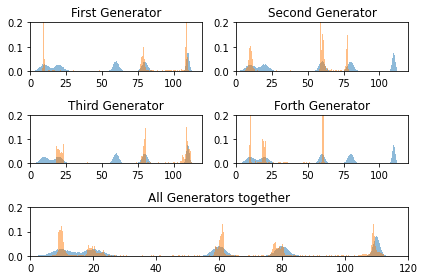

Epoch 481/500
390/390 [==============================] - 19s 48ms/step - g_loss0: 0.7268 - g_loss1: 0.7353 - g_loss2: 0.6930 - g_loss3: 0.7558 - d_loss: 1.1369
Epoch 482/500
390/390 [==============================] - 18s 46ms/step - g_loss0: 0.7360 - g_loss1: 0.7141 - g_loss2: 0.7018 - g_loss3: 0.7378 - d_loss: 1.1332
Epoch 483/500
390/390 [==============================] - 18s 47ms/step - g_loss0: 0.7221 - g_loss1: 0.7177 - g_loss2: 0.7237 - g_loss3: 0.7461 - d_loss: 1.2056
Epoch 484/500
390/390 [==============================] - 19s 49ms/step - g_loss0: 0.7415 - g_loss1: 0.7334 - g_loss2: 0.7309 - g_loss3: 0.7638 - d_loss: 1.1714
Epoch 485/500
390/390 [==============================] - 19s 48ms/step - g_loss0: 0.7276 - g_loss1: 0.7280 - g_loss2: 0.7197 - g_loss3: 0.7522 - d_loss: 1.1659


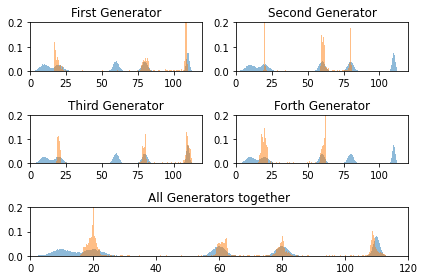

Epoch 486/500
390/390 [==============================] - 18s 47ms/step - g_loss0: 0.7345 - g_loss1: 0.7157 - g_loss2: 0.7059 - g_loss3: 0.7625 - d_loss: 1.1706
Epoch 487/500
390/390 [==============================] - 18s 47ms/step - g_loss0: 0.7208 - g_loss1: 0.7167 - g_loss2: 0.7081 - g_loss3: 0.7498 - d_loss: 1.1368
Epoch 488/500
390/390 [==============================] - 18s 45ms/step - g_loss0: 0.7384 - g_loss1: 0.7302 - g_loss2: 0.7198 - g_loss3: 0.7544 - d_loss: 1.1692
Epoch 489/500
390/390 [==============================] - 20s 52ms/step - g_loss0: 0.7170 - g_loss1: 0.7345 - g_loss2: 0.7325 - g_loss3: 0.7381 - d_loss: 1.1406
Epoch 490/500
390/390 [==============================] - 18s 46ms/step - g_loss0: 0.7074 - g_loss1: 0.7272 - g_loss2: 0.7222 - g_loss3: 0.7320 - d_loss: 1.1729


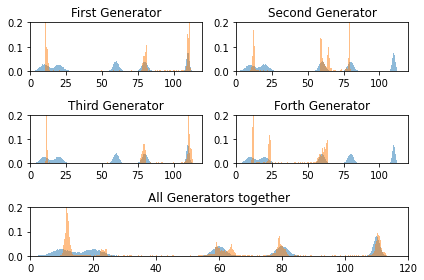

Epoch 491/500
390/390 [==============================] - 19s 48ms/step - g_loss0: 0.7399 - g_loss1: 0.7226 - g_loss2: 0.7185 - g_loss3: 0.7364 - d_loss: 1.1759
Epoch 492/500
390/390 [==============================] - 18s 46ms/step - g_loss0: 0.7281 - g_loss1: 0.6984 - g_loss2: 0.7119 - g_loss3: 0.7359 - d_loss: 1.1557
Epoch 493/500
390/390 [==============================] - 20s 50ms/step - g_loss0: 0.7199 - g_loss1: 0.7267 - g_loss2: 0.7237 - g_loss3: 0.7383 - d_loss: 1.1670
Epoch 494/500
390/390 [==============================] - 19s 49ms/step - g_loss0: 0.7204 - g_loss1: 0.7212 - g_loss2: 0.7195 - g_loss3: 0.7302 - d_loss: 1.1680
Epoch 495/500
390/390 [==============================] - 19s 48ms/step - g_loss0: 0.7044 - g_loss1: 0.7203 - g_loss2: 0.7189 - g_loss3: 0.7332 - d_loss: 1.1317


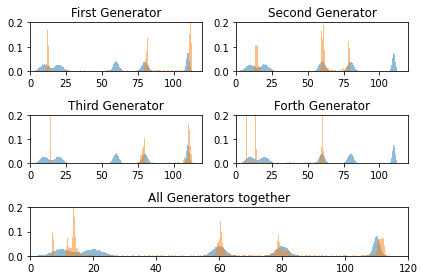

Epoch 496/500
390/390 [==============================] - 18s 46ms/step - g_loss0: 0.7382 - g_loss1: 0.7027 - g_loss2: 0.7064 - g_loss3: 0.7602 - d_loss: 1.1981
Epoch 497/500
390/390 [==============================] - 19s 49ms/step - g_loss0: 0.7071 - g_loss1: 0.7184 - g_loss2: 0.7116 - g_loss3: 0.7382 - d_loss: 1.1381
Epoch 498/500
390/390 [==============================] - 18s 47ms/step - g_loss0: 0.7238 - g_loss1: 0.7226 - g_loss2: 0.7093 - g_loss3: 0.7679 - d_loss: 1.1861
Epoch 499/500
390/390 [==============================] - 21s 53ms/step - g_loss0: 0.7032 - g_loss1: 0.7222 - g_loss2: 0.7192 - g_loss3: 0.7521 - d_loss: 1.1521
Epoch 500/500
390/390 [==============================] - 18s 47ms/step - g_loss0: 0.6974 - g_loss1: 0.7164 - g_loss2: 0.7116 - g_loss3: 0.7554 - d_loss: 1.1369


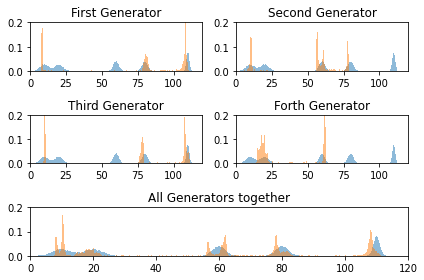

In [ ]:
madgan.fit(dataset, epochs = 500, initial_epoch = 400, steps_per_epoch = steps_per_epoch, verbose = 1, callbacks = my_callbacks)

Epoch 501/600
390/390 [==============================] - 20s 48ms/step - g_loss0: 0.7098 - g_loss1: 0.7024 - g_loss2: 0.7067 - g_loss3: 0.7321 - d_loss: 1.1526
Epoch 502/600
390/390 [==============================] - 18s 46ms/step - g_loss0: 0.7215 - g_loss1: 0.7279 - g_loss2: 0.7309 - g_loss3: 0.7264 - d_loss: 1.1458
Epoch 503/600
390/390 [==============================] - 19s 48ms/step - g_loss0: 0.7424 - g_loss1: 0.7238 - g_loss2: 0.7344 - g_loss3: 0.6870 - d_loss: 1.1343
Epoch 504/600
390/390 [==============================] - 19s 49ms/step - g_loss0: 0.7166 - g_loss1: 0.7197 - g_loss2: 0.7228 - g_loss3: 0.7314 - d_loss: 1.1540
Epoch 505/600
390/390 [==============================] - 19s 48ms/step - g_loss0: 0.7482 - g_loss1: 0.7028 - g_loss2: 0.7199 - g_loss3: 0.7302 - d_loss: 1.1440


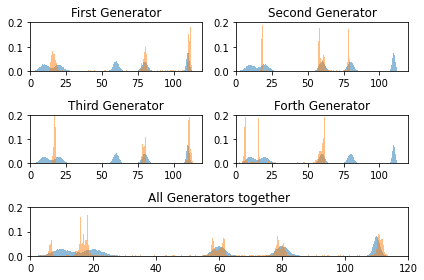

Epoch 506/600
390/390 [==============================] - 18s 46ms/step - g_loss0: 0.7128 - g_loss1: 0.7193 - g_loss2: 0.7234 - g_loss3: 0.7214 - d_loss: 1.1570
Epoch 507/600
390/390 [==============================] - 19s 49ms/step - g_loss0: 0.7534 - g_loss1: 0.7246 - g_loss2: 0.7132 - g_loss3: 0.7846 - d_loss: 1.2092
Epoch 508/600
390/390 [==============================] - 18s 46ms/step - g_loss0: 0.6960 - g_loss1: 0.7209 - g_loss2: 0.7176 - g_loss3: 0.7495 - d_loss: 1.1611
Epoch 509/600
390/390 [==============================] - 20s 52ms/step - g_loss0: 0.7324 - g_loss1: 0.7119 - g_loss2: 0.7083 - g_loss3: 0.7526 - d_loss: 1.1844
Epoch 510/600
390/390 [==============================] - 18s 46ms/step - g_loss0: 0.7207 - g_loss1: 0.7102 - g_loss2: 0.6993 - g_loss3: 0.7454 - d_loss: 1.1375


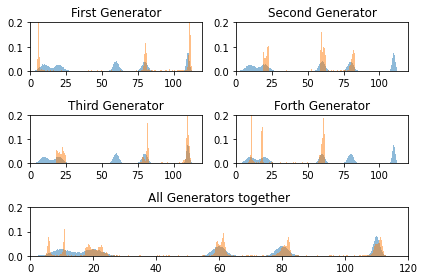

Epoch 511/600
390/390 [==============================] - 19s 48ms/step - g_loss0: 0.7162 - g_loss1: 0.7108 - g_loss2: 0.7043 - g_loss3: 0.7283 - d_loss: 1.1442
Epoch 512/600
390/390 [==============================] - 18s 46ms/step - g_loss0: 0.7193 - g_loss1: 0.7136 - g_loss2: 0.7140 - g_loss3: 0.7413 - d_loss: 1.1828
Epoch 513/600
390/390 [==============================] - 19s 49ms/step - g_loss0: 0.7071 - g_loss1: 0.7165 - g_loss2: 0.7157 - g_loss3: 0.7410 - d_loss: 1.1322
Epoch 514/600
390/390 [==============================] - 19s 49ms/step - g_loss0: 0.7322 - g_loss1: 0.7300 - g_loss2: 0.7205 - g_loss3: 0.7392 - d_loss: 1.2000
Epoch 515/600
390/390 [==============================] - 20s 50ms/step - g_loss0: 0.7011 - g_loss1: 0.7241 - g_loss2: 0.7155 - g_loss3: 0.7325 - d_loss: 1.1465


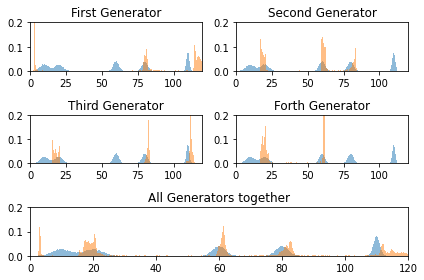

Epoch 516/600
390/390 [==============================] - 18s 46ms/step - g_loss0: 0.7027 - g_loss1: 0.7077 - g_loss2: 0.7063 - g_loss3: 0.7300 - d_loss: 1.1417
Epoch 517/600
390/390 [==============================] - 19s 50ms/step - g_loss0: 0.7072 - g_loss1: 0.7303 - g_loss2: 0.7236 - g_loss3: 0.7198 - d_loss: 1.1526
Epoch 518/600
390/390 [==============================] - 18s 47ms/step - g_loss0: 0.6966 - g_loss1: 0.7392 - g_loss2: 0.7350 - g_loss3: 0.7303 - d_loss: 1.1387
Epoch 519/600
390/390 [==============================] - 20s 51ms/step - g_loss0: 0.7336 - g_loss1: 0.7168 - g_loss2: 0.7086 - g_loss3: 0.7469 - d_loss: 1.1728
Epoch 520/600
390/390 [==============================] - 18s 46ms/step - g_loss0: 0.7445 - g_loss1: 0.7043 - g_loss2: 0.7045 - g_loss3: 0.7537 - d_loss: 1.1642


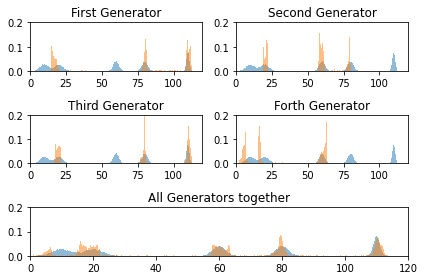

Epoch 521/600
390/390 [==============================] - 19s 48ms/step - g_loss0: 0.7102 - g_loss1: 0.7253 - g_loss2: 0.7289 - g_loss3: 0.7084 - d_loss: 1.1836
Epoch 522/600
390/390 [==============================] - 18s 47ms/step - g_loss0: 0.6977 - g_loss1: 0.7306 - g_loss2: 0.7320 - g_loss3: 0.7035 - d_loss: 1.1684
Epoch 523/600
390/390 [==============================] - 19s 48ms/step - g_loss0: 0.7222 - g_loss1: 0.6995 - g_loss2: 0.7085 - g_loss3: 0.7285 - d_loss: 1.1474
Epoch 524/600
390/390 [==============================] - 20s 50ms/step - g_loss0: 0.7243 - g_loss1: 0.7262 - g_loss2: 0.7252 - g_loss3: 0.7288 - d_loss: 1.1609
Epoch 525/600
390/390 [==============================] - 19s 48ms/step - g_loss0: 0.7077 - g_loss1: 0.7254 - g_loss2: 0.7192 - g_loss3: 0.7368 - d_loss: 1.1540


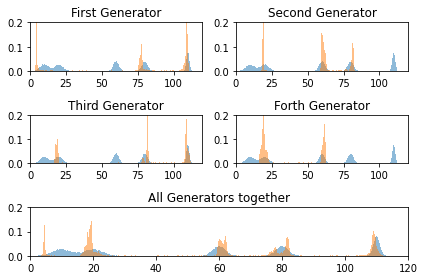

Epoch 526/600
390/390 [==============================] - 18s 45ms/step - g_loss0: 0.7033 - g_loss1: 0.7089 - g_loss2: 0.7046 - g_loss3: 0.7495 - d_loss: 1.1443
Epoch 527/600
390/390 [==============================] - 19s 50ms/step - g_loss0: 0.7289 - g_loss1: 0.7174 - g_loss2: 0.7145 - g_loss3: 0.7213 - d_loss: 1.1702
Epoch 528/600
390/390 [==============================] - 18s 47ms/step - g_loss0: 0.6942 - g_loss1: 0.7386 - g_loss2: 0.7234 - g_loss3: 0.7673 - d_loss: 1.1560
Epoch 529/600
390/390 [==============================] - 21s 53ms/step - g_loss0: 0.7085 - g_loss1: 0.7274 - g_loss2: 0.7180 - g_loss3: 0.7519 - d_loss: 1.1675
Epoch 530/600
390/390 [==============================] - 19s 48ms/step - g_loss0: 0.7077 - g_loss1: 0.7236 - g_loss2: 0.7151 - g_loss3: 0.7526 - d_loss: 1.1656


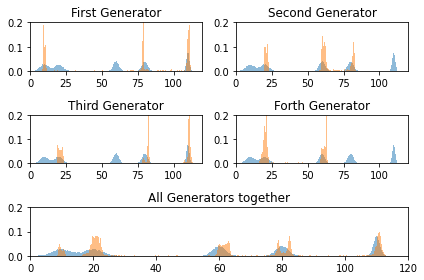

Epoch 531/600
390/390 [==============================] - 19s 49ms/step - g_loss0: 0.7065 - g_loss1: 0.7184 - g_loss2: 0.7142 - g_loss3: 0.7524 - d_loss: 1.1583
Epoch 532/600
390/390 [==============================] - 18s 47ms/step - g_loss0: 0.7033 - g_loss1: 0.7220 - g_loss2: 0.7157 - g_loss3: 0.7572 - d_loss: 1.1547
Epoch 533/600
390/390 [==============================] - 20s 51ms/step - g_loss0: 0.7173 - g_loss1: 0.7184 - g_loss2: 0.7087 - g_loss3: 0.7637 - d_loss: 1.1736
Epoch 534/600
390/390 [==============================] - 19s 49ms/step - g_loss0: 0.7027 - g_loss1: 0.7208 - g_loss2: 0.7149 - g_loss3: 0.7522 - d_loss: 1.1563
Epoch 535/600
390/390 [==============================] - 20s 50ms/step - g_loss0: 0.7171 - g_loss1: 0.7217 - g_loss2: 0.7177 - g_loss3: 0.7531 - d_loss: 1.1697


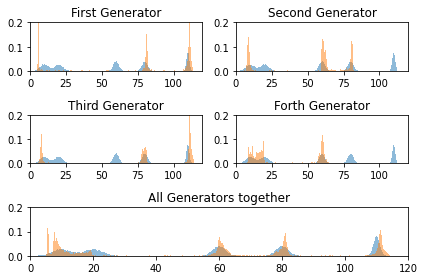

Epoch 536/600
390/390 [==============================] - 18s 47ms/step - g_loss0: 0.7185 - g_loss1: 0.7154 - g_loss2: 0.7135 - g_loss3: 0.7183 - d_loss: 1.1523
Epoch 537/600
390/390 [==============================] - 20s 52ms/step - g_loss0: 0.7227 - g_loss1: 0.7200 - g_loss2: 0.7174 - g_loss3: 0.7059 - d_loss: 1.1690
Epoch 538/600
390/390 [==============================] - 19s 49ms/step - g_loss0: 0.7415 - g_loss1: 0.7277 - g_loss2: 0.7130 - g_loss3: 0.7741 - d_loss: 1.1861
Epoch 539/600
390/390 [==============================] - 21s 54ms/step - g_loss0: 0.7062 - g_loss1: 0.7277 - g_loss2: 0.7314 - g_loss3: 0.7220 - d_loss: 1.1457
Epoch 540/600
390/390 [==============================] - 19s 50ms/step - g_loss0: 0.7212 - g_loss1: 0.7205 - g_loss2: 0.7116 - g_loss3: 0.7592 - d_loss: 1.1726


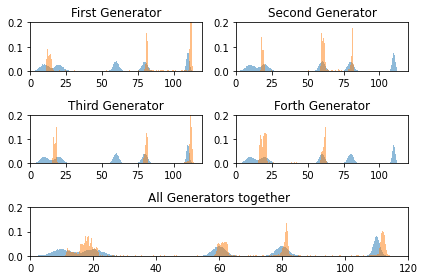

Epoch 541/600
390/390 [==============================] - 20s 51ms/step - g_loss0: 0.7089 - g_loss1: 0.7286 - g_loss2: 0.7214 - g_loss3: 0.7412 - d_loss: 1.1694
Epoch 542/600
390/390 [==============================] - 19s 49ms/step - g_loss0: 0.7152 - g_loss1: 0.7260 - g_loss2: 0.7236 - g_loss3: 0.7256 - d_loss: 1.1727
Epoch 543/600
390/390 [==============================] - 20s 52ms/step - g_loss0: 0.7193 - g_loss1: 0.7211 - g_loss2: 0.7189 - g_loss3: 0.7182 - d_loss: 1.1710
Epoch 544/600
390/390 [==============================] - 20s 52ms/step - g_loss0: 0.7231 - g_loss1: 0.7241 - g_loss2: 0.7249 - g_loss3: 0.7118 - d_loss: 1.1509
Epoch 545/600
390/390 [==============================] - 20s 52ms/step - g_loss0: 0.7252 - g_loss1: 0.7167 - g_loss2: 0.7148 - g_loss3: 0.7051 - d_loss: 1.1571


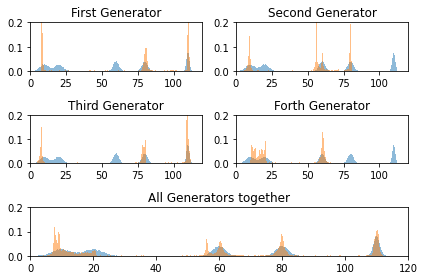

Epoch 546/600
390/390 [==============================] - 19s 49ms/step - g_loss0: 0.7206 - g_loss1: 0.7079 - g_loss2: 0.7138 - g_loss3: 0.7078 - d_loss: 1.1198
Epoch 547/600
390/390 [==============================] - 20s 52ms/step - g_loss0: 0.7160 - g_loss1: 0.7147 - g_loss2: 0.7082 - g_loss3: 0.6907 - d_loss: 1.0864
Epoch 548/600
390/390 [==============================] - 19s 50ms/step - g_loss0: 0.7279 - g_loss1: 0.7276 - g_loss2: 0.7172 - g_loss3: 0.7193 - d_loss: 1.2084
Epoch 549/600
390/390 [==============================] - 21s 54ms/step - g_loss0: 0.7118 - g_loss1: 0.7146 - g_loss2: 0.7106 - g_loss3: 0.7225 - d_loss: 1.1423
Epoch 550/600
390/390 [==============================] - 19s 50ms/step - g_loss0: 0.7053 - g_loss1: 0.7203 - g_loss2: 0.7192 - g_loss3: 0.7312 - d_loss: 1.1666


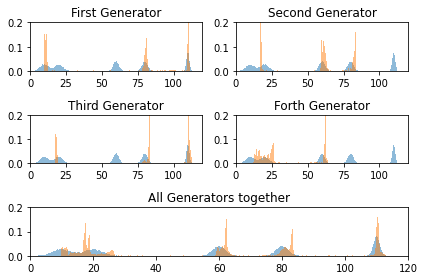

Epoch 551/600
390/390 [==============================] - 19s 49ms/step - g_loss0: 0.7052 - g_loss1: 0.7371 - g_loss2: 0.7294 - g_loss3: 0.7230 - d_loss: 1.1699
Epoch 552/600
390/390 [==============================] - 19s 49ms/step - g_loss0: 0.7098 - g_loss1: 0.7228 - g_loss2: 0.7177 - g_loss3: 0.7150 - d_loss: 1.1552
Epoch 553/600
390/390 [==============================] - 20s 53ms/step - g_loss0: 0.7199 - g_loss1: 0.7182 - g_loss2: 0.7190 - g_loss3: 0.7104 - d_loss: 1.1701
Epoch 554/600
390/390 [==============================] - 20s 52ms/step - g_loss0: 0.7280 - g_loss1: 0.7148 - g_loss2: 0.7028 - g_loss3: 0.7679 - d_loss: 1.1871
Epoch 555/600
390/390 [==============================] - 20s 52ms/step - g_loss0: 0.7081 - g_loss1: 0.7325 - g_loss2: 0.7226 - g_loss3: 0.7097 - d_loss: 1.1472


In [ ]:
madgan.fit(dataset, epochs = 600, initial_epoch = 500, steps_per_epoch = steps_per_epoch, verbose = 1, callbacks = my_callbacks)

# Saving GIF file

In [ ]:
anim_file = 'madgan.gif'

with imageio.get_writer(f'/content/drive/MyDrive/{dir_name}/{anim_file}', mode='I') as writer:
    filenames = glob.glob(f'/content/drive/MyDrive/{dir_name}/Charts/chart*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        # image = image[::4,::4,:]
        writer.append_data(image)
        writer.append_data(image)
    for i in range(20):
        writer.append_data(image)   

# Reduce GIF size
optimize(f'/content/drive/MyDrive/{dir_name}/{anim_file}')